## TWO-STAGE CLUSTER ANALYSIS: EARLY PREPAYMENTS CUSTOMER SEGMENTATION

#### Import Libraries

In [1]:

# data handling
import pandas as pd
import numpy as np
# data visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
import seaborn as sns
# data science
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from scipy.stats import chi2_contingency

# to augment data
import random

#ignore wa
import warnings
warnings.filterwarnings('ignore')

#remove scientific notation
pd.options.display.float_format = '{:.2f}'.format

#### Functions

In [2]:
### Storing functions at the top for cleaner code tracking

## data augmentation to increase sample size of data
def data_augment(df, augment_factor, seed):
    random.seed(seed) #set seed
    sample_size = int(len(df)*augment_factor) 
    random_sample_indices = random.sample(list(df.index), sample_size)
    sample_df = df.loc[random_sample_indices].copy()

    raw_augmented_df = pd.concat([df, sample_df], ignore_index=False)

    raw_augmented_df = raw_augmented_df.reset_index()

    return raw_augmented_df



In [3]:
def data_transformation(df, today):
    # Convert to dates for calculation
    df['LOAN_OPEN_DATE'] = pd.to_datetime(df['LOAN_OPEN_DATE'])
    df['LOAN_END_DATE'] = pd.to_datetime(df['LOAN_END_DATE'])

    # Add derived fields for cohorts
    df['OPEN_YEAR'] = df['LOAN_OPEN_DATE'].dt.year
    df['OPEN_QTR'] = df['LOAN_OPEN_DATE'].dt.quarter
    df['OPEN_YRQTR'] = df['OPEN_YEAR'].astype(str) + 'Q' + df['OPEN_QTR'].astype(str)

    # Calculate months_on_book
    df['MONTHS_ON_BOOK'] = ((today.year - df['LOAN_OPEN_DATE'].dt.year) * 12 + 
                            today.month - df['LOAN_OPEN_DATE'].dt.month)  
    
    # Calculate Payoff Periods
    df['DAYS_TO_PAYOFF'] = (pd.to_datetime(df['PAYOFF_DATE'])-pd.to_datetime(df['LOAN_OPEN_DATE'])).dt.days
    df['MONTHS_TO_PAYOFF'] = round(((df['DAYS_TO_PAYOFF']/365)*12))
    df['MONTHS_TO_PAYOFF'].loc[(df['IS_PAID_OFF'] == 'YES') & (df['MONTHS_TO_PAYOFF'] == 0.0)] = 1
    df['MONTHS_TO_PAYOFF'].loc[(df['IS_PAID_OFF'] == 'NO') & (df['MONTHS_TO_PAYOFF'] == 0.0)] = 1

    ## Calculate Percentage of loan paid off
    df['PERCENT_COMPLETED'] = ((today - df['LOAN_OPEN_DATE']).dt.days)/((df['LOAN_END_DATE']-df['LOAN_OPEN_DATE']).dt.days)*100
    df['PERCENT_COMPLETED'].loc[(df['IS_PAID_OFF'] == 'YES') ] = 1

    df['PAYOFF_DATE'] = pd.to_datetime(df['PAYOFF_DATE'])
    df['PERCENT_TERM_COMPLETED'] = (df['PAYOFF_DATE'] - df['LOAN_OPEN_DATE'])/(df['LOAN_END_DATE'] - df['LOAN_OPEN_DATE'])*100

    return df

In [4]:
# Leveraging  matplotlib's RdYlBu_r colormap to create a built in scale for the barchart
def get_colors_method1(values, min_val=2, max_val=12):
    # Normalize values to 0-1 range
    normalized = (np.array(values) - min_val) / (max_val - min_val)
    
    # Use reverse RdYlBu colormap (blue to red)
    cmap = plt.cm.RdBu_r
    colors = [cmap(norm_val) for norm_val in normalized]
    
    return colors

#### Import Data

In [5]:
raw_df = pd.read_csv("AUTO_PREPAYMENT_DATA.csv").set_index('CUSTOMER_ID')

In [6]:
df = data_augment(raw_df, 0.5, 42)

##### Transform Data

In [7]:
today = pd.to_datetime('3/31/2025')

In [8]:
df = data_transformation(df, today)

In [9]:
print(f"Number of columns: {len(df.columns)}")
print(f"Number of rows: {len(df.index)}")

Number of columns: 26
Number of rows: 65050


### PART 1: COHORT ANALYSIS - EXPLORATION OF ORIGINATION SEGMENTS 

#### COHORT PREPAYMENT ANALYSIS - YEAR

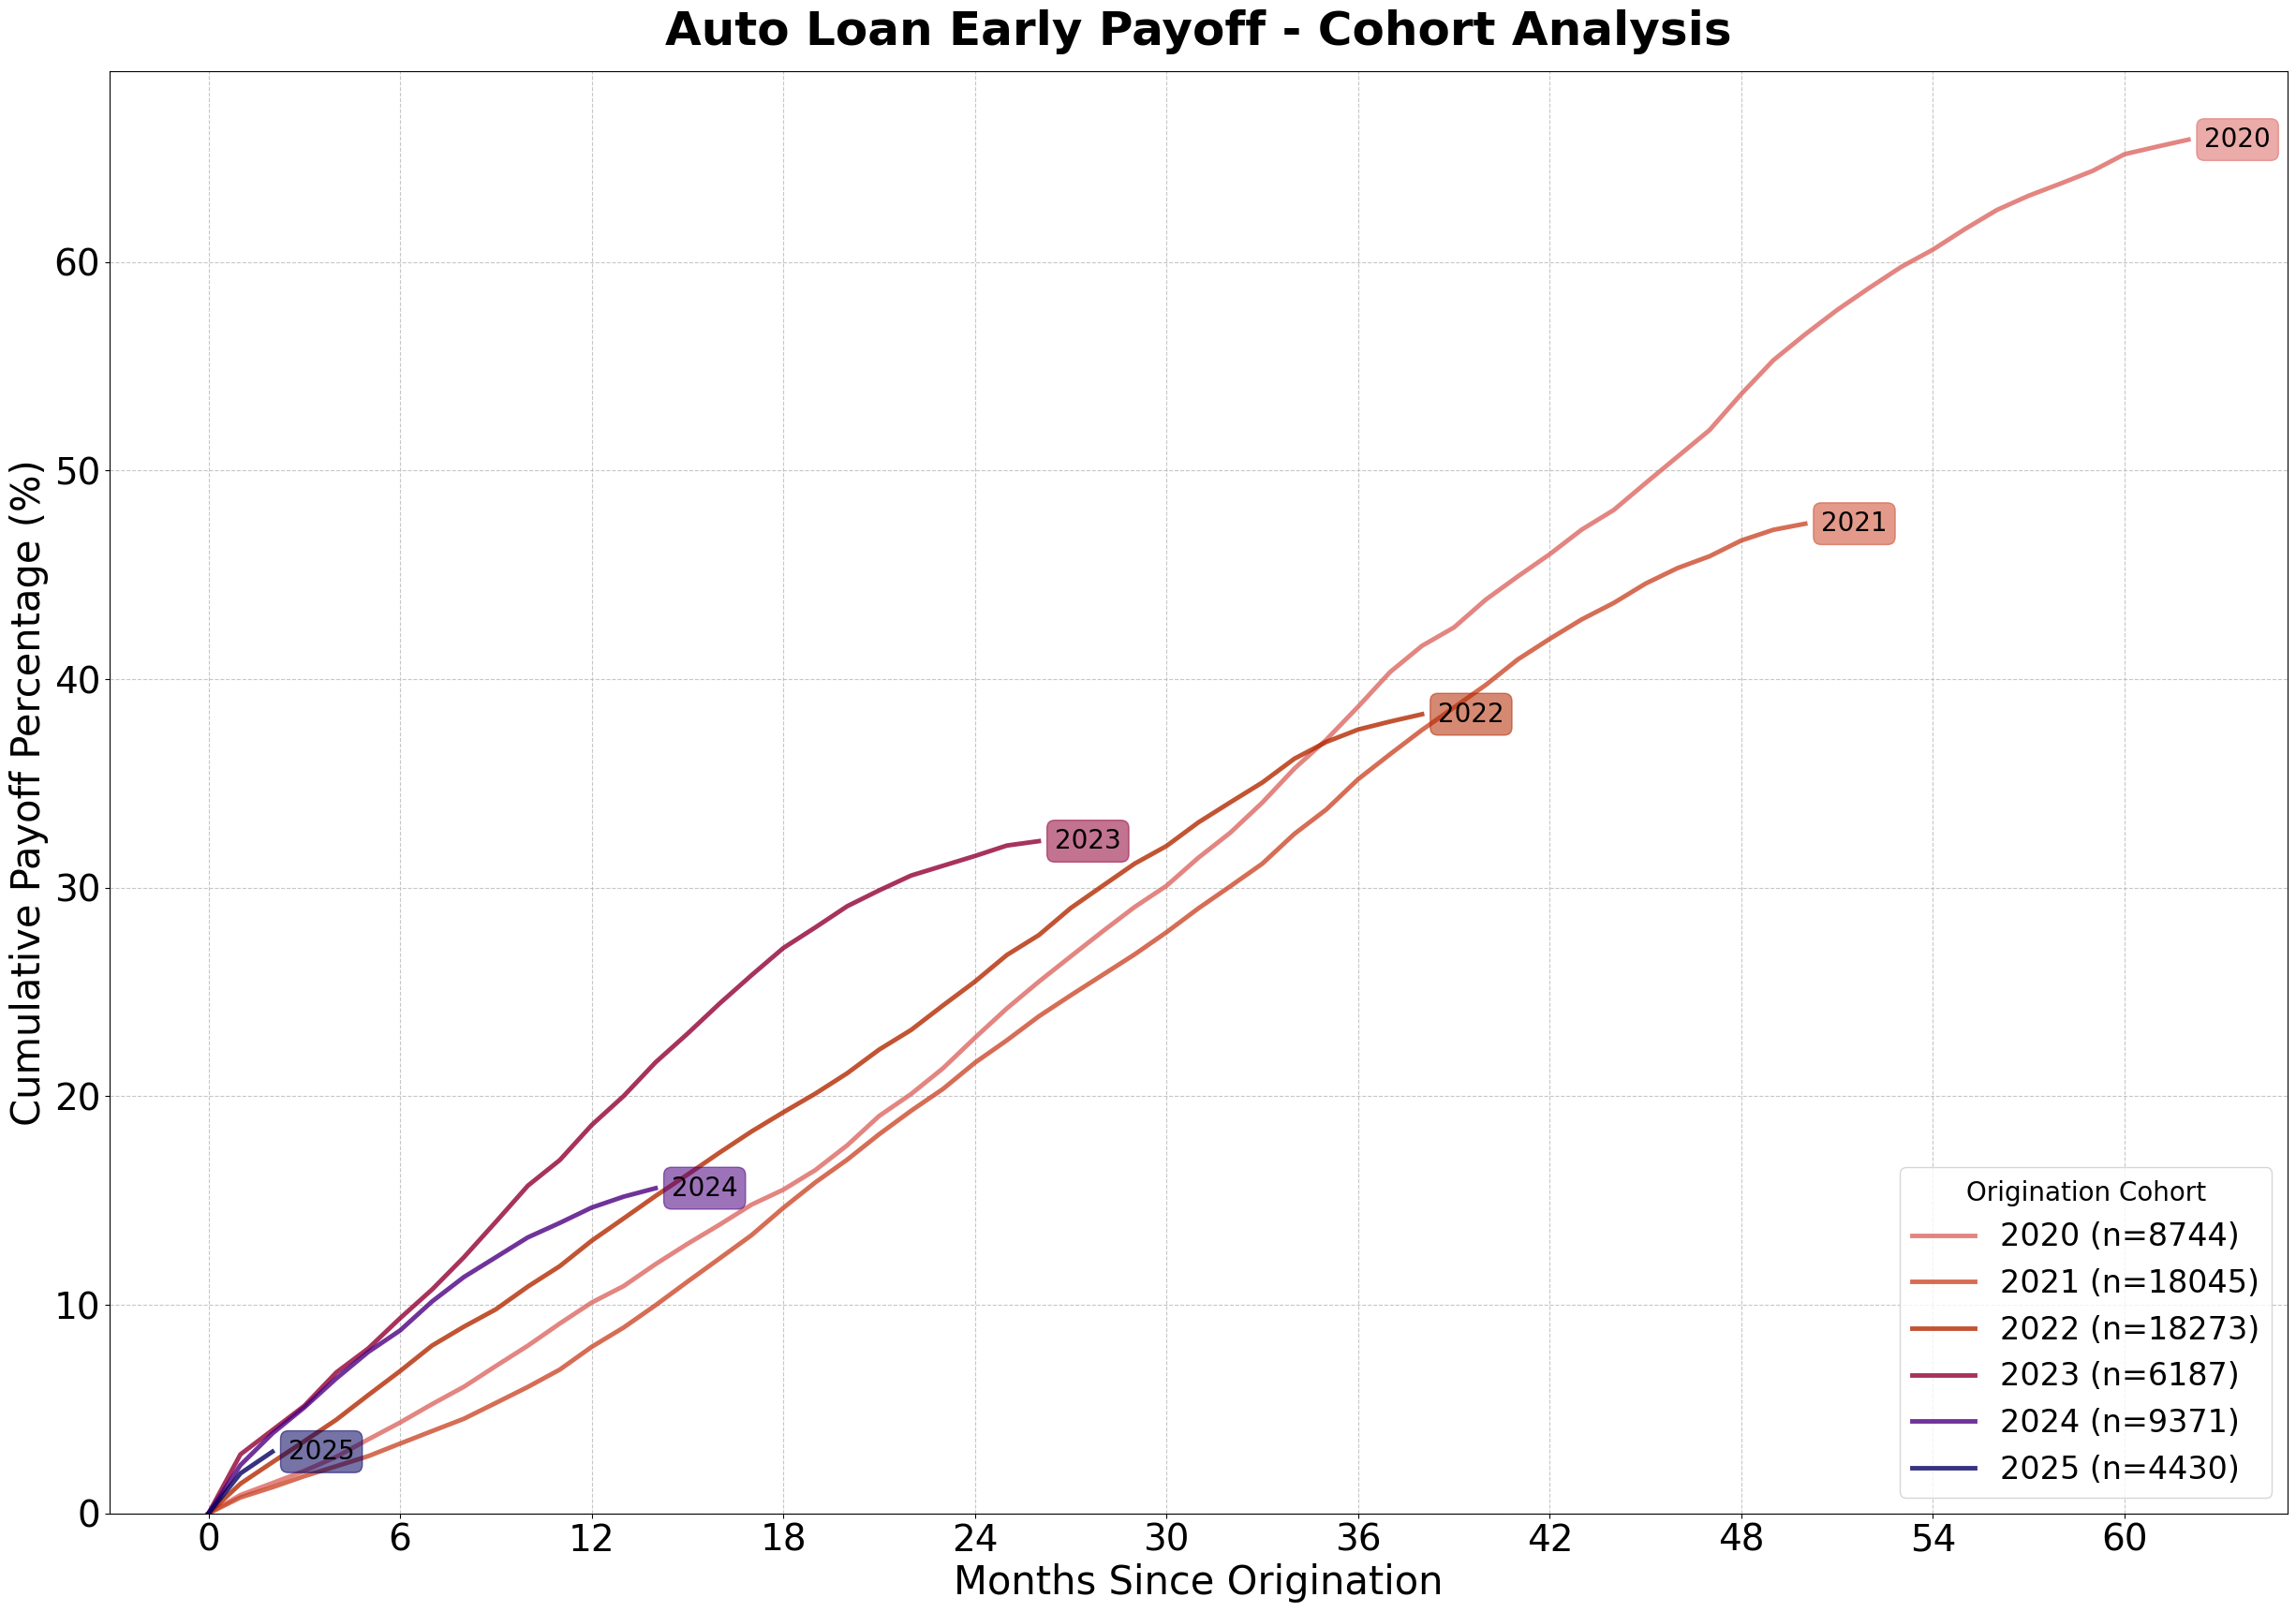

In [10]:
# Only include cohorts with enough loans for statistical reliability
cohort_counts = df.groupby('OPEN_YEAR').size()
valid_cohorts = cohort_counts.index.to_list()

# Filter to valid cohorts and sort chronologically
valid_cohorts.sort()

# Track maximum month to set x-axis limit
max_month = 0

colors = [
    '#dc6762', '#cc482b', '#b32900',  '#910035', '#4c0081', '#050060'
]

fig, ax = plt.subplots(1, figsize=(30, 20))
plt.rcParams.update({'font.size': 20})
# Dictionary to store the cumulative payoff percentages for each cohort
cumulative_percents = {}
    
for i, cohort in enumerate(valid_cohorts):
    # Get all loans in this cohort
    cohort_loans = df[df['OPEN_YEAR'] == cohort]
    total_loans = len(cohort_loans)
        
    # Calculate the maximum months on book for this cohort
    max_cohort_month = cohort_loans['MONTHS_ON_BOOK'].max()
    max_month = max(max_month, max_cohort_month)
        
    # Create a monthly timeline for this cohort
    months = range(0, max_cohort_month + 1)
    cumulative_percents[cohort] = []

    # For each month, calculate the cumulative percentage of loans paid off
    for month in months:
        # Count loans paid off by this month
        paid_off_count = ((cohort_loans['IS_PAID_OFF'] == 'YES') & 
                             (cohort_loans['MONTHS_TO_PAYOFF'] <= month)).sum()
            
        # Calculate cumulative percentage
        cumulative_percent = (paid_off_count / total_loans) * 100
        cumulative_percents[cohort].append(cumulative_percent)
        #print(cumulative_percents[cohort])
    # Plot the cumulative payoff curve for this cohort
    plt.plot(months, cumulative_percents[cohort], 
                 marker='', linewidth=3.5, alpha=0.8, 
                 label=f'{cohort} (n={total_loans})',
                 color=colors[i])
    
    # Add Label to the right of each line
    if cumulative_percents[cohort]:
        last_month = months[-1]
        last_value = cumulative_percents[cohort][-1]

        t = plt.text(last_month + 0.5, last_value, f'{cohort}',
                 fontsize=20,
                 verticalalignment='center', fontweight='medium', color='black')
        t.set_bbox(dict(facecolor=colors[i], alpha=0.55, edgecolor=colors[i], boxstyle='round'))
    
# Add labels and formatting
plt.xlabel('Months Since Origination', fontsize=30)
plt.ylabel('Cumulative Payoff Percentage (%)', fontsize=30)
plt.title('Auto Loan Early Payoff - Cohort Analysis', fontsize=36, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Origination Cohort', loc='lower right', fontsize=24)

# Format x-axis to show every 6 months
plt.xticks(range(0, max_month + 1, 6), fontsize=28)
    
# Set y-axis to reasonable limit

plt.ylim(0, max(50, plt.ylim()[1]))
plt.yticks(fontsize=28) 
#plt.tight_layout()

plt.savefig('auto_loan_cohort_analysis.png', dpi=300)
plt.show() 

The cohort analysis reveals a dramatic shift in early payoff behavior coinciding with the Federal Reserve's aggressive rate hiking cycle that began in 2022. The 2023 and 2024 vintage cohorts demonstrate substantially accelerated prepayment patterns compared to the 2020-2022 baseline period, with early payoff rates nearly doubling at comparable loan ages.

#### COHORT PREPAYMENT ANALYSIS - MOVEMENT

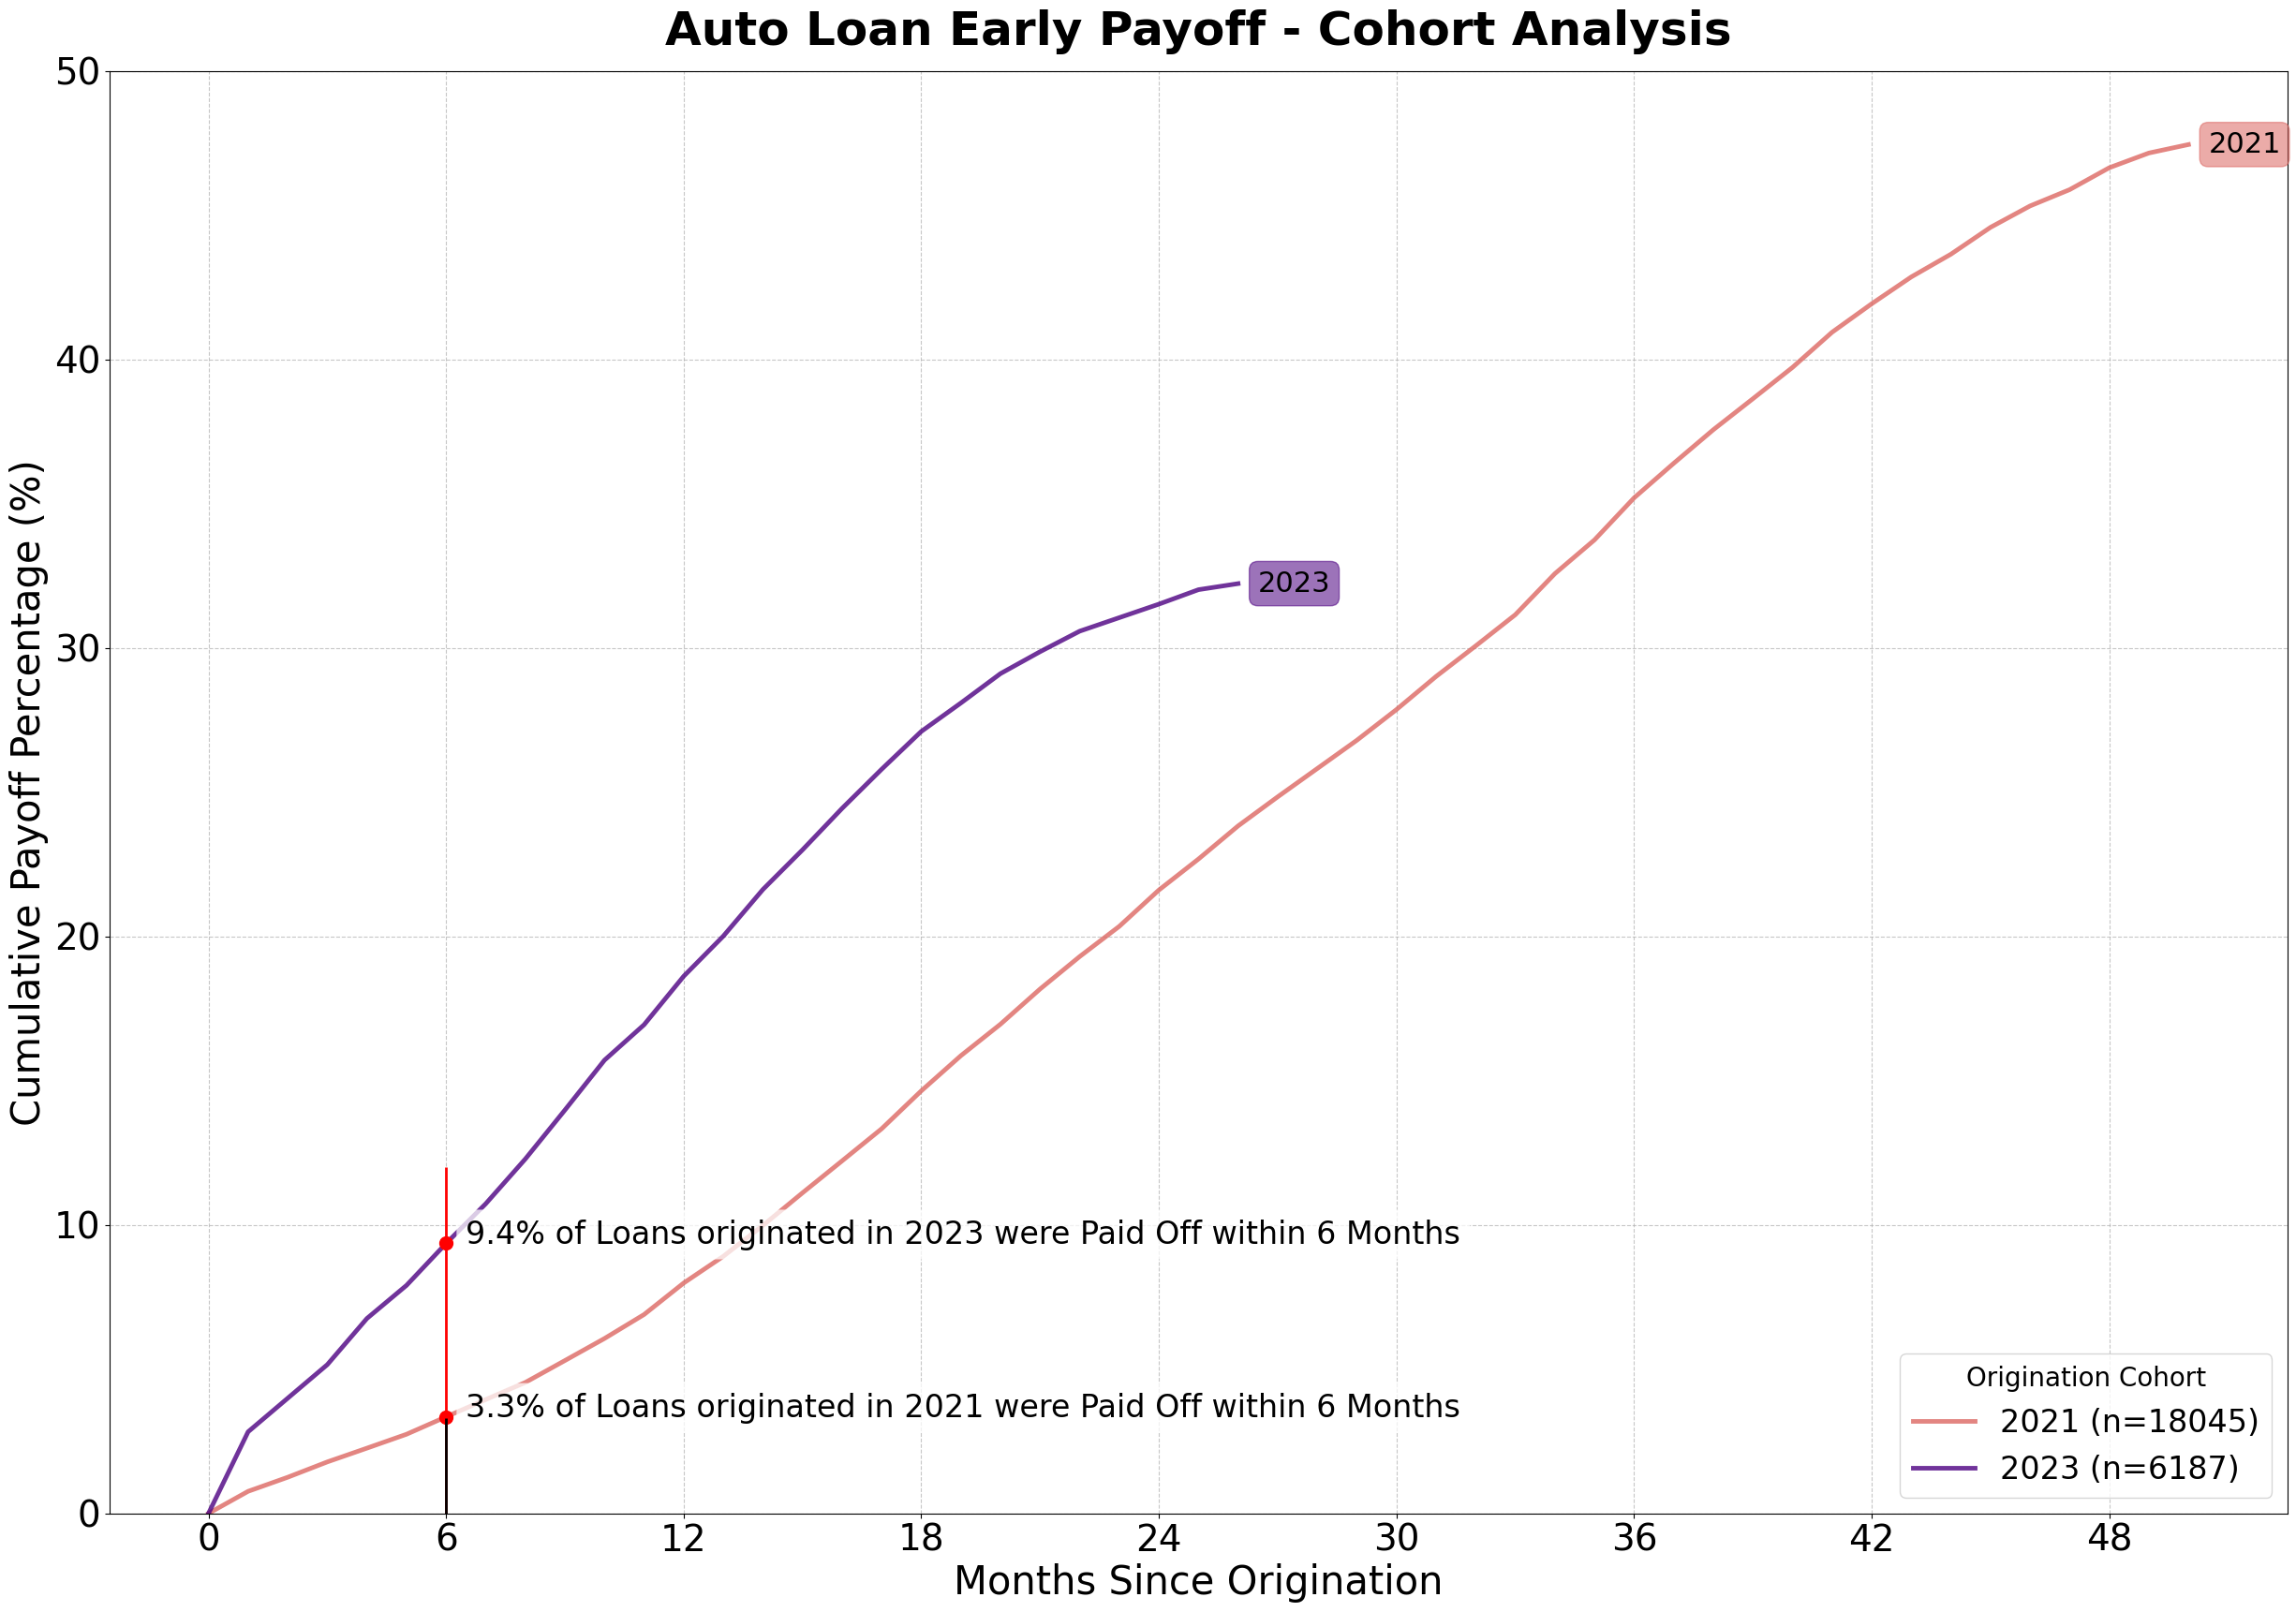

In [11]:
# Only include cohorts with enough loans for statistical reliability
cohort_counts = df.groupby('OPEN_YEAR').size()
valid_cohorts = cohort_counts.index.to_list()

valid_cohorts = [2021, 2023]
# Filter to valid cohorts and sort chronologically
valid_cohorts.sort()

# Track maximum month to set x-axis limit
max_month = 0

colors = [
    '#dc6762', 
    #'#cc482b', '#b32900',  '#910035', 
    '#4c0081'#, '#050060'
]

fig, ax = plt.subplots(1, figsize=(30, 20))
plt.rcParams.update({'font.size': 20})
# Dictionary to store the cumulative payoff percentages for each cohort
cumulative_percents = {}
    
for i, cohort in enumerate(valid_cohorts):
    # Get all loans in this cohort
    cohort_loans = df[df['OPEN_YEAR'] == cohort]
    total_loans = len(cohort_loans)
        
    # Calculate the maximum months on book for this cohort
    max_cohort_month = cohort_loans['MONTHS_ON_BOOK'].max()
    max_month = max(max_month, max_cohort_month)
        
    # Create a monthly timeline for this cohort
    months = range(0, max_cohort_month + 1)
    cumulative_percents[cohort] = []

    # For each month, calculate the cumulative percentage of loans paid off
    for month in months:
        # Count loans paid off by this month
        paid_off_count = ((cohort_loans['IS_PAID_OFF'] == 'YES') & 
                             (cohort_loans['MONTHS_TO_PAYOFF'] <= month)).sum()
            
        # Calculate cumulative percentage
        cumulative_percent = (paid_off_count / total_loans) * 100
        cumulative_percents[cohort].append(cumulative_percent)
        #print(cumulative_percents[cohort])
    # Plot the cumulative payoff curve for this cohort
    plt.plot(months, cumulative_percents[cohort], 
                 marker='', linewidth=3.5, alpha=0.8, 
                 label=f'{cohort} (n={total_loans})',
                 color=colors[i])
    
    #add example leader lines
    ax.plot(6, cumulative_percents[cohort][6], marker='o', markersize=10, color='red')
    ax.text(6.5, cumulative_percents[cohort][6], f"{cumulative_percents[cohort][6]:.1f}% of Loans originated in {cohort} were Paid Off within 6 Months", fontsize=24).set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='none', boxstyle='round'))
    
    # Add Label to the right of each line
    if cumulative_percents[cohort]:
        last_month = months[-1]
        last_value = cumulative_percents[cohort][-1]

        t = plt.text(last_month + 0.5, last_value, f'{cohort}',
                 fontsize=22,
                 verticalalignment='center', fontweight='medium', color='black')
        t.set_bbox(dict(facecolor=colors[i], alpha=0.55, edgecolor=colors[i], boxstyle='round'))
    
ax.vlines(6, 0, 12, colors='Red', linewidth = 2)


ax.vlines(6, 0, 3.3, colors='black', linewidth = 2)

    
# Add labels and formatting
plt.xlabel('Months Since Origination', fontsize=30)
plt.ylabel('Cumulative Payoff Percentage (%)', fontsize=30)
plt.title('Auto Loan Early Payoff - Cohort Analysis', fontsize=36, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Origination Cohort', loc='lower right', fontsize=24)

# Format x-axis to show every 6 months
plt.xticks(range(0, max_month + 1, 6), fontsize=28)
    
# Set y-axis to reasonable limit

plt.ylim(0, max(50, plt.ylim()[1]))
plt.yticks(fontsize=28) 
#plt.tight_layout()

plt.savefig('auto_loan_cohort_analysis.png', dpi=300)
plt.show() 

Dramatic Early Payoff Acceleration: Nearly 3x Increase During Rate Hiking Cycle

The comparative analysis between the 2021 and 2023 origination cohorts reveals the profound impact of the Federal Reserve's monetary policy shift on borrower behavior. The stark contrast in early payoff patterns provides compelling evidence of how macroeconomic conditions drive consumer financial decision-making.

#### YEAR-QUARTER COHORT PREPAYMENTS AT 6 MONTHS

In [12]:
month6_df = df.groupby('OPEN_YRQTR').apply(lambda x: (x['MONTHS_TO_PAYOFF'] <= 6).mean() * 100).reset_index()

In [13]:
month6_df[0][10:]

10    8.19
11    8.74
12   10.59
13    9.20
14    9.32
15    8.56
16    9.16
17    8.19
18    9.00
19    8.80
20    5.11
21    1.58
Name: 0, dtype: float64

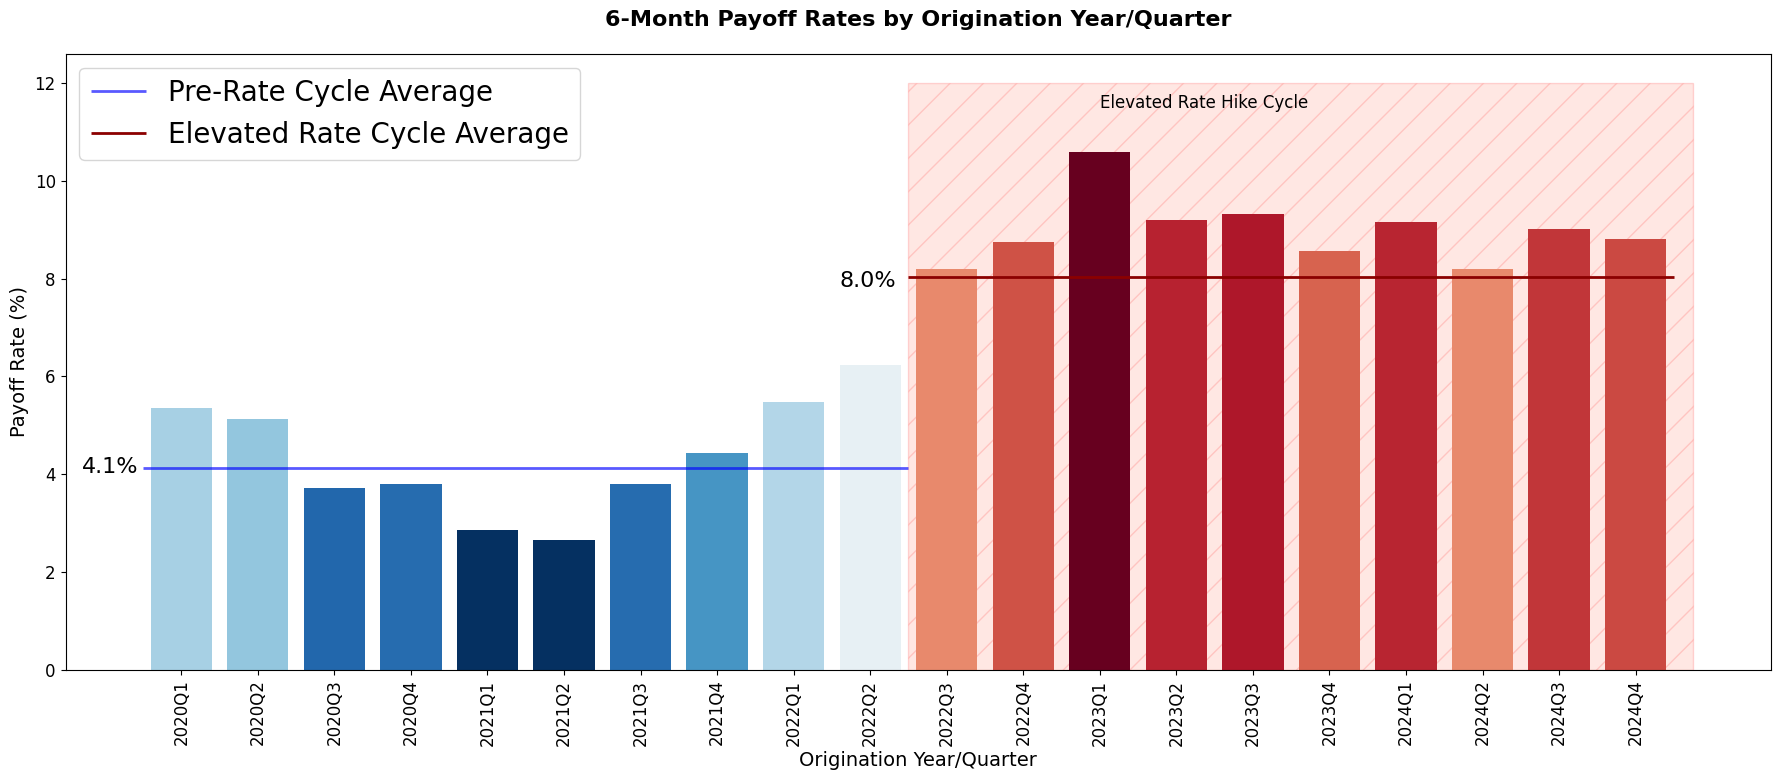

In [14]:
plt.figure(figsize=(22,8))

#Create a Rectangle patch
plt.gca().add_patch(Rectangle((9.5,0), 10.25, 12, linewidth=1, hatch='/', edgecolor='r', facecolor='tomato', alpha=0.15))
plt.text(12, 11.5, "Elevated Rate Hike Cycle", fontsize=12)

plt.bar(month6_df['OPEN_YRQTR'][:-2], month6_df[0][:-2], color = get_colors_method1(month6_df[0][:-2], min_val=3, max_val=10))
plt.hlines(month6_df[0][:9].mean(), -0.5, 9.5, linestyle='-', linewidth=2, color='blue', alpha=0.65, label='Pre-Rate Cycle Average')
plt.text(-1.30, month6_df[0][:9].mean()-.1, f"{round(month6_df[0][:9].mean(), 1)}%", fontsize=16)

plt.hlines(month6_df[0][10:].mean(), 9.5, 19.5, linestyle='-', linewidth=2, color='darkred', label= "Elevated Rate Cycle Average")
plt.text(8.60, month6_df[0][10:].mean()-.2, f"{round(month6_df[0][10:].mean(), 1)}%", fontsize=16)

plt.xlabel('Origination Year/Quarter', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Payoff Rate (%)', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='upper left')
plt.title('6-Month Payoff Rates by Origination Year/Quarter', fontsize=16, fontweight='bold', pad=20)

plt.show();

The quarterly breakdown of 6-month payoff rates provides definitive evidence of a structural shift in borrower behavior that coincides precisely with the Federal Reserve's monetary policy inflection point. The data reveals a clear demarcation between the pre-rate cycle and elevated rate environments, establishing Q3 2022 as the critical transition period for early prepayment behavior.

##### Year Quarter Cohorts by  Fed Funds Rate Hike

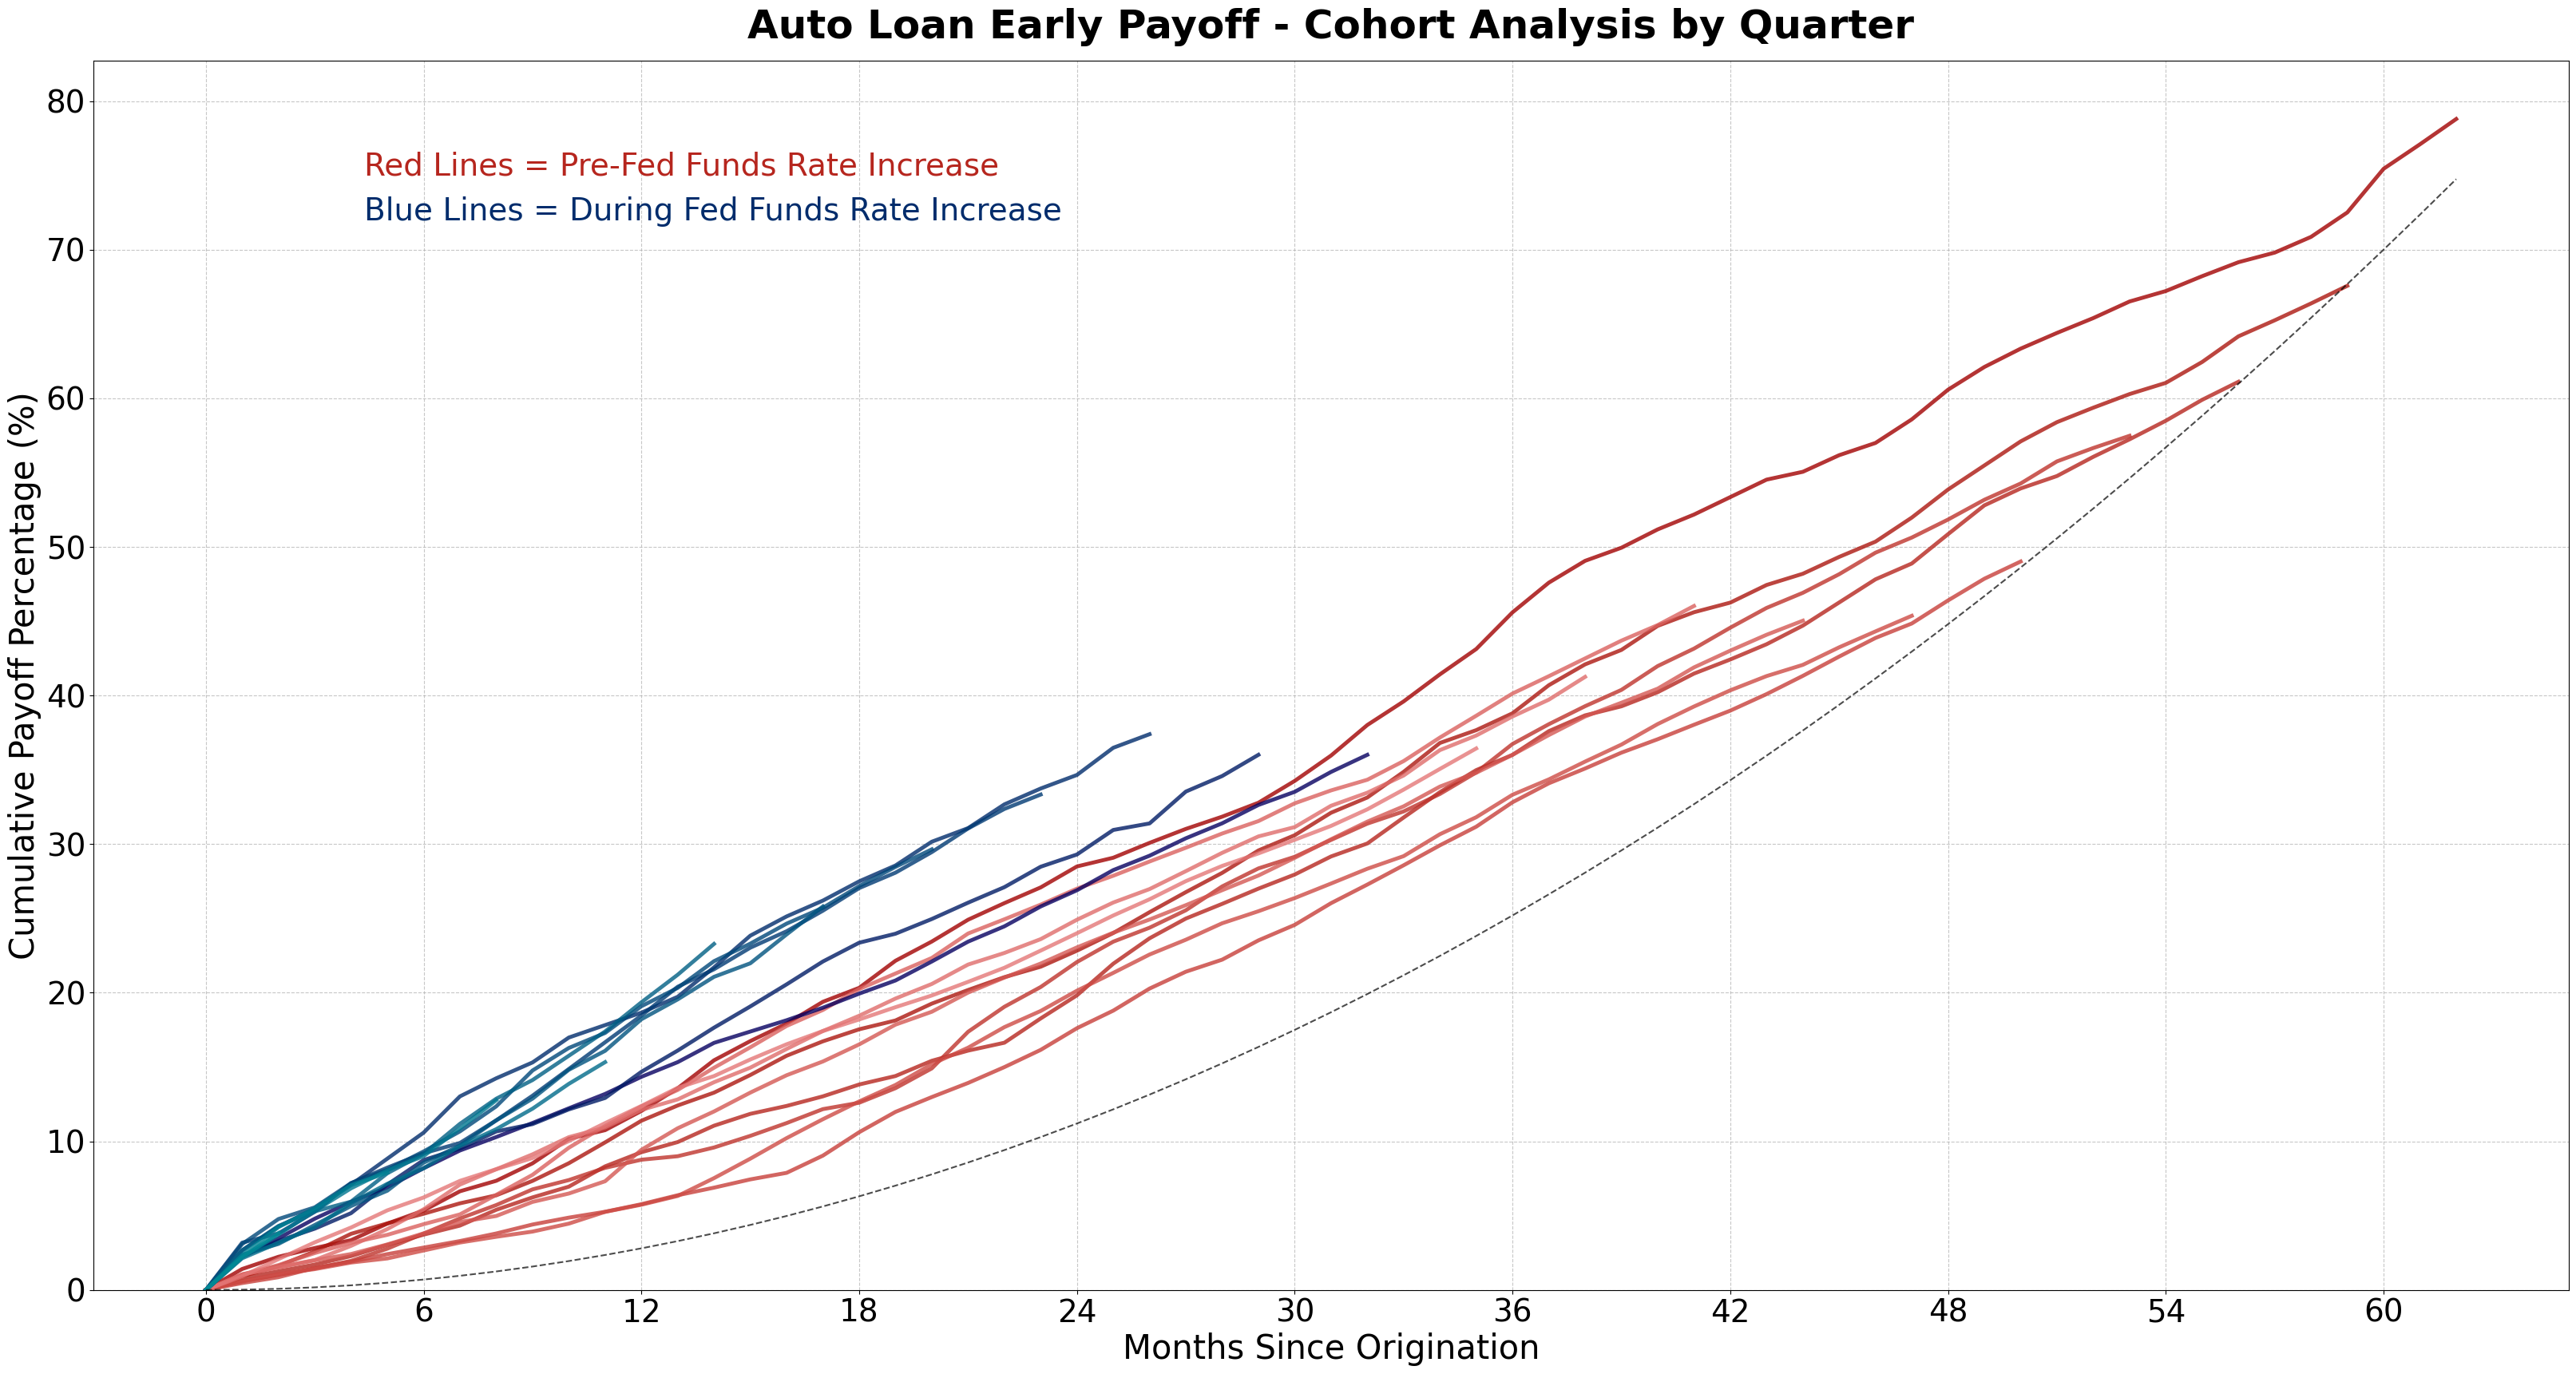

In [15]:
cohort_VAR = 'OPEN_YRQTR'

# Only include cohorts with enough loans for statistical reliability
cohort_counts = df.groupby(cohort_VAR).size()
valid_cohorts = cohort_counts.index.to_list()

#valid_cohorts = [
#    '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2','2021Q3', '2021Q4', '2022Q1', '2022Q2',
#    '2022Q3', '2022Q4', '2023Q1','2023Q2', '2023Q3','2023Q4','2024Q1','2024Q2','2024Q3','2024Q4','2025Q1','2025Q2'
#    ]

# Filter to valid cohorts and sort chronologically
valid_cohorts.sort()


#get color palette
colors= [
    '#a20101', '#ac170f', '#b6261e', '#be332c', '#c73f39', '#ce4b45', '#d45752', '#da615e', '#df6c6a', '#e47777', 
    '#060061', '#001b65', '#002c6c', '#003a73', '#004779', '#00537f', '#005f84', '#006b8a', '#00768f', '#008193', '#008b96', '#009699'
         ]

# Track maximum month to set x-axis limit
max_month = 0

fig, ax = plt.subplots(1, figsize=(40, 20))
plt.rcParams.update({'font.size': 20})
# Dictionary to store the cumulative payoff percentages for each cohort
cumulative_percents = {}
    
for i, cohort in enumerate(valid_cohorts):
    # Get all loans in this cohort
    cohort_loans = df[df[cohort_VAR] == cohort]
    total_loans = len(cohort_loans)
        
    # Calculate the maximum months on book for this cohort
    max_cohort_month = cohort_loans['MONTHS_ON_BOOK'].max()
    max_month = max(max_month, max_cohort_month)
        
    # Create a monthly timeline for this cohort
    months = range(0, max_cohort_month + 1)
    cumulative_percents[cohort] = []

    # For each month, calculate the cumulative percentage of loans paid off
    for month in months:
        # Count loans paid off by this month
        paid_off_count = ((cohort_loans['IS_PAID_OFF'] == 'YES') & 
                             (cohort_loans['MONTHS_TO_PAYOFF'] <= month)).sum()
            
        # Calculate cumulative percentage
        cumulative_percent = (paid_off_count / total_loans) * 100
        cumulative_percents[cohort].append(cumulative_percent)
        #print(cumulative_percents[cohort])
    # Plot the cumulative payoff curve for this cohort
    plt.plot(months, cumulative_percents[cohort], 
                 marker='', linewidth=3.5, alpha=0.8, 
                 label=f'{cohort} (n={total_loans})',
                 color=colors[i])
    
    
# Create an expected payoff curve (illustrative)
expected_months = range(0, max_month + 1)
expected_payoff = [2 * (month/60)**2 * 35 for month in expected_months]  # Quadratic curve capped at ~35%
plt.plot(expected_months, expected_payoff, 'k--', linewidth=1.5, alpha=0.7, label='Expected Payoff')
    
# Add labels and formatting
plt.xlabel('Months Since Origination', fontsize=30)
plt.ylabel('Cumulative Payoff Percentage (%)', fontsize=30)
plt.title('Auto Loan Early Payoff - Cohort Analysis by Quarter', fontsize=36, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend(title='Origination Cohort', loc='lower right', fontsize=16)
    
plt.text(4.35, 75, 'Red Lines = Pre-Fed Funds Rate Increase', {'fontsize':28, 'color': '#b6261e'})
plt.text(4.35, 72, 'Blue Lines = During Fed Funds Rate Increase', {'fontsize':28, 'color': '#002c6c'})

# Format x-axis to show every 6 months
plt.xticks(range(0, max_month + 1, 6), fontsize=28)
plt.yticks(fontsize=28)
    
# Set y-axis to reasonable limit
plt.ylim(0, max(50, plt.ylim()[1]))
    
#plt.tight_layout()

plt.savefig('auto_loan_cohort_analysis.png', dpi=300)
plt.show() 

This quarterly cohort analysis provides compelling visual evidence of the Federal Reserve's rate hiking cycle impact on auto loan prepayment patterns. The clear color separation between pre-rate increase (red) and rate increase period (blue) cohorts demonstrates a fundamental behavioral shift that goes beyond normal portfolio variation.

#### Rate Distribution and Paydown Spreads

In [16]:
PRE_FED = ['2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2','2021Q3', '2021Q4', '2022Q1', '2022Q2']
POST_FED = ['2022Q3', '2022Q4', '2023Q1','2023Q2', '2023Q3','2023Q4','2024Q1','2024Q2','2024Q3','2024Q4','2025Q1','2025Q2']

df['PRE_FED'] = 0

df['PRE_FED'].loc[(df['OPEN_YRQTR'].isin(PRE_FED))] = 1

df['PRE_FED'].loc[df['PRE_FED'] == 1] = 'PRE-FED FUNDS RATE INCREASE'
df['PRE_FED'].loc[df['PRE_FED'] == 0] = 'FED FUNDS RATE INCREASE'

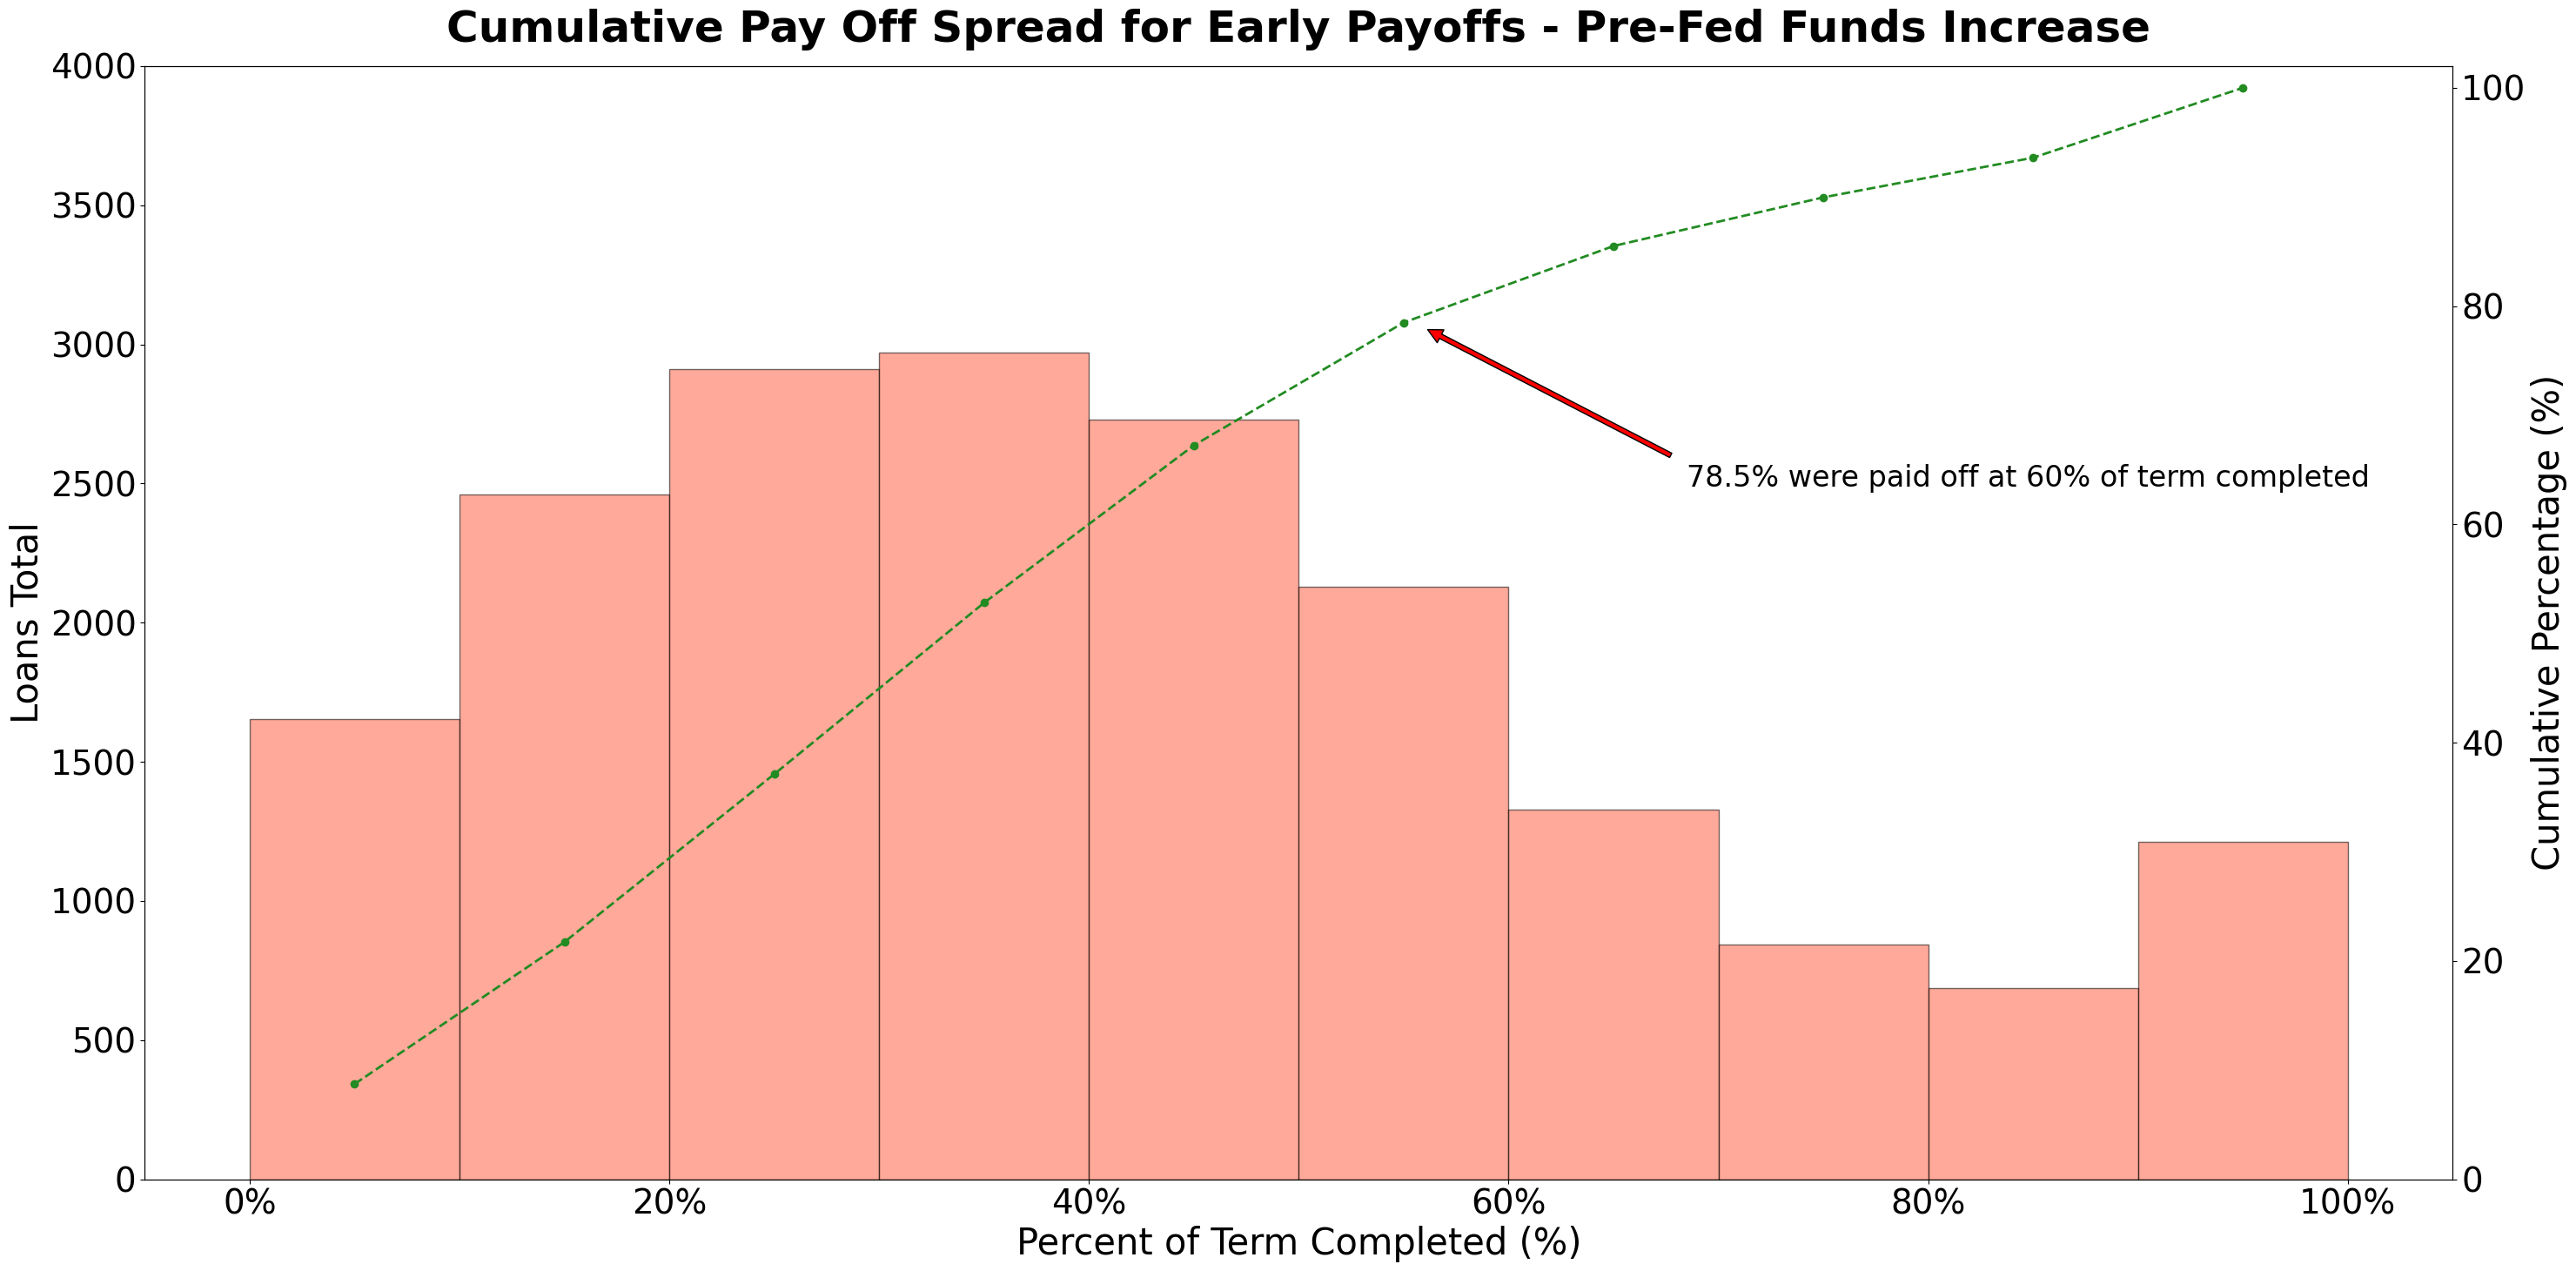

In [17]:
# Only include paid off loans
paid_off_loans = df[(df['IS_PAID_OFF'] == 'YES') & (df['PRE_FED'] == 'PRE-FED FUNDS RATE INCREASE')]
    
fig, ax1 = plt.subplots(figsize=(30, 15))
    
# Create histogram
n, bins, patches = ax1.hist(
        paid_off_loans['PERCENT_TERM_COMPLETED'],  # Convert to percentage
        bins=10,
        alpha=0.55,
        color='tomato',
        edgecolor='black'
)
ax1.set_ylim(0, 4000)
ax1.set_yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
ax1.set_yticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000], fontsize=28)
ax1.set_xticklabels(['','0%', '20%', '40%', '60%', '80%', '100%'], fontsize=28)
ax1.set_ylabel('Loans Total', fontsize=30)
ax1.set_xlabel('Percent of Term Completed (%)', fontsize=30)

bin_centers = 0.5 * (bins[1:] + bins[:-1])

cumulative = np.cumsum(n) / sum(n) * 100
ax2 = plt.twinx()
ax2.plot(bin_centers, cumulative, color='forestgreen', linestyle='--', 
             linewidth=2, marker='o', label='Cumulative Distribution')
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=30)
ax2.set_ylim(0, 102)
ax2.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=28)


ax2.annotate(f'{cumulative[5]:.1f}% were paid off at 60% of term completed',
                 xy=(cumulative[5]-23, cumulative[5]),
                 xytext=(cumulative[5]-10, cumulative[5]-15),
                 arrowprops=dict(facecolor='red', shrink=0.05),
                 fontsize=24)

plt.title('Cumulative Pay Off Spread for Early Payoffs - Pre-Fed Funds Increase', fontsize=36, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('auto_loan_life_histogram.png', dpi=300)
plt.show()

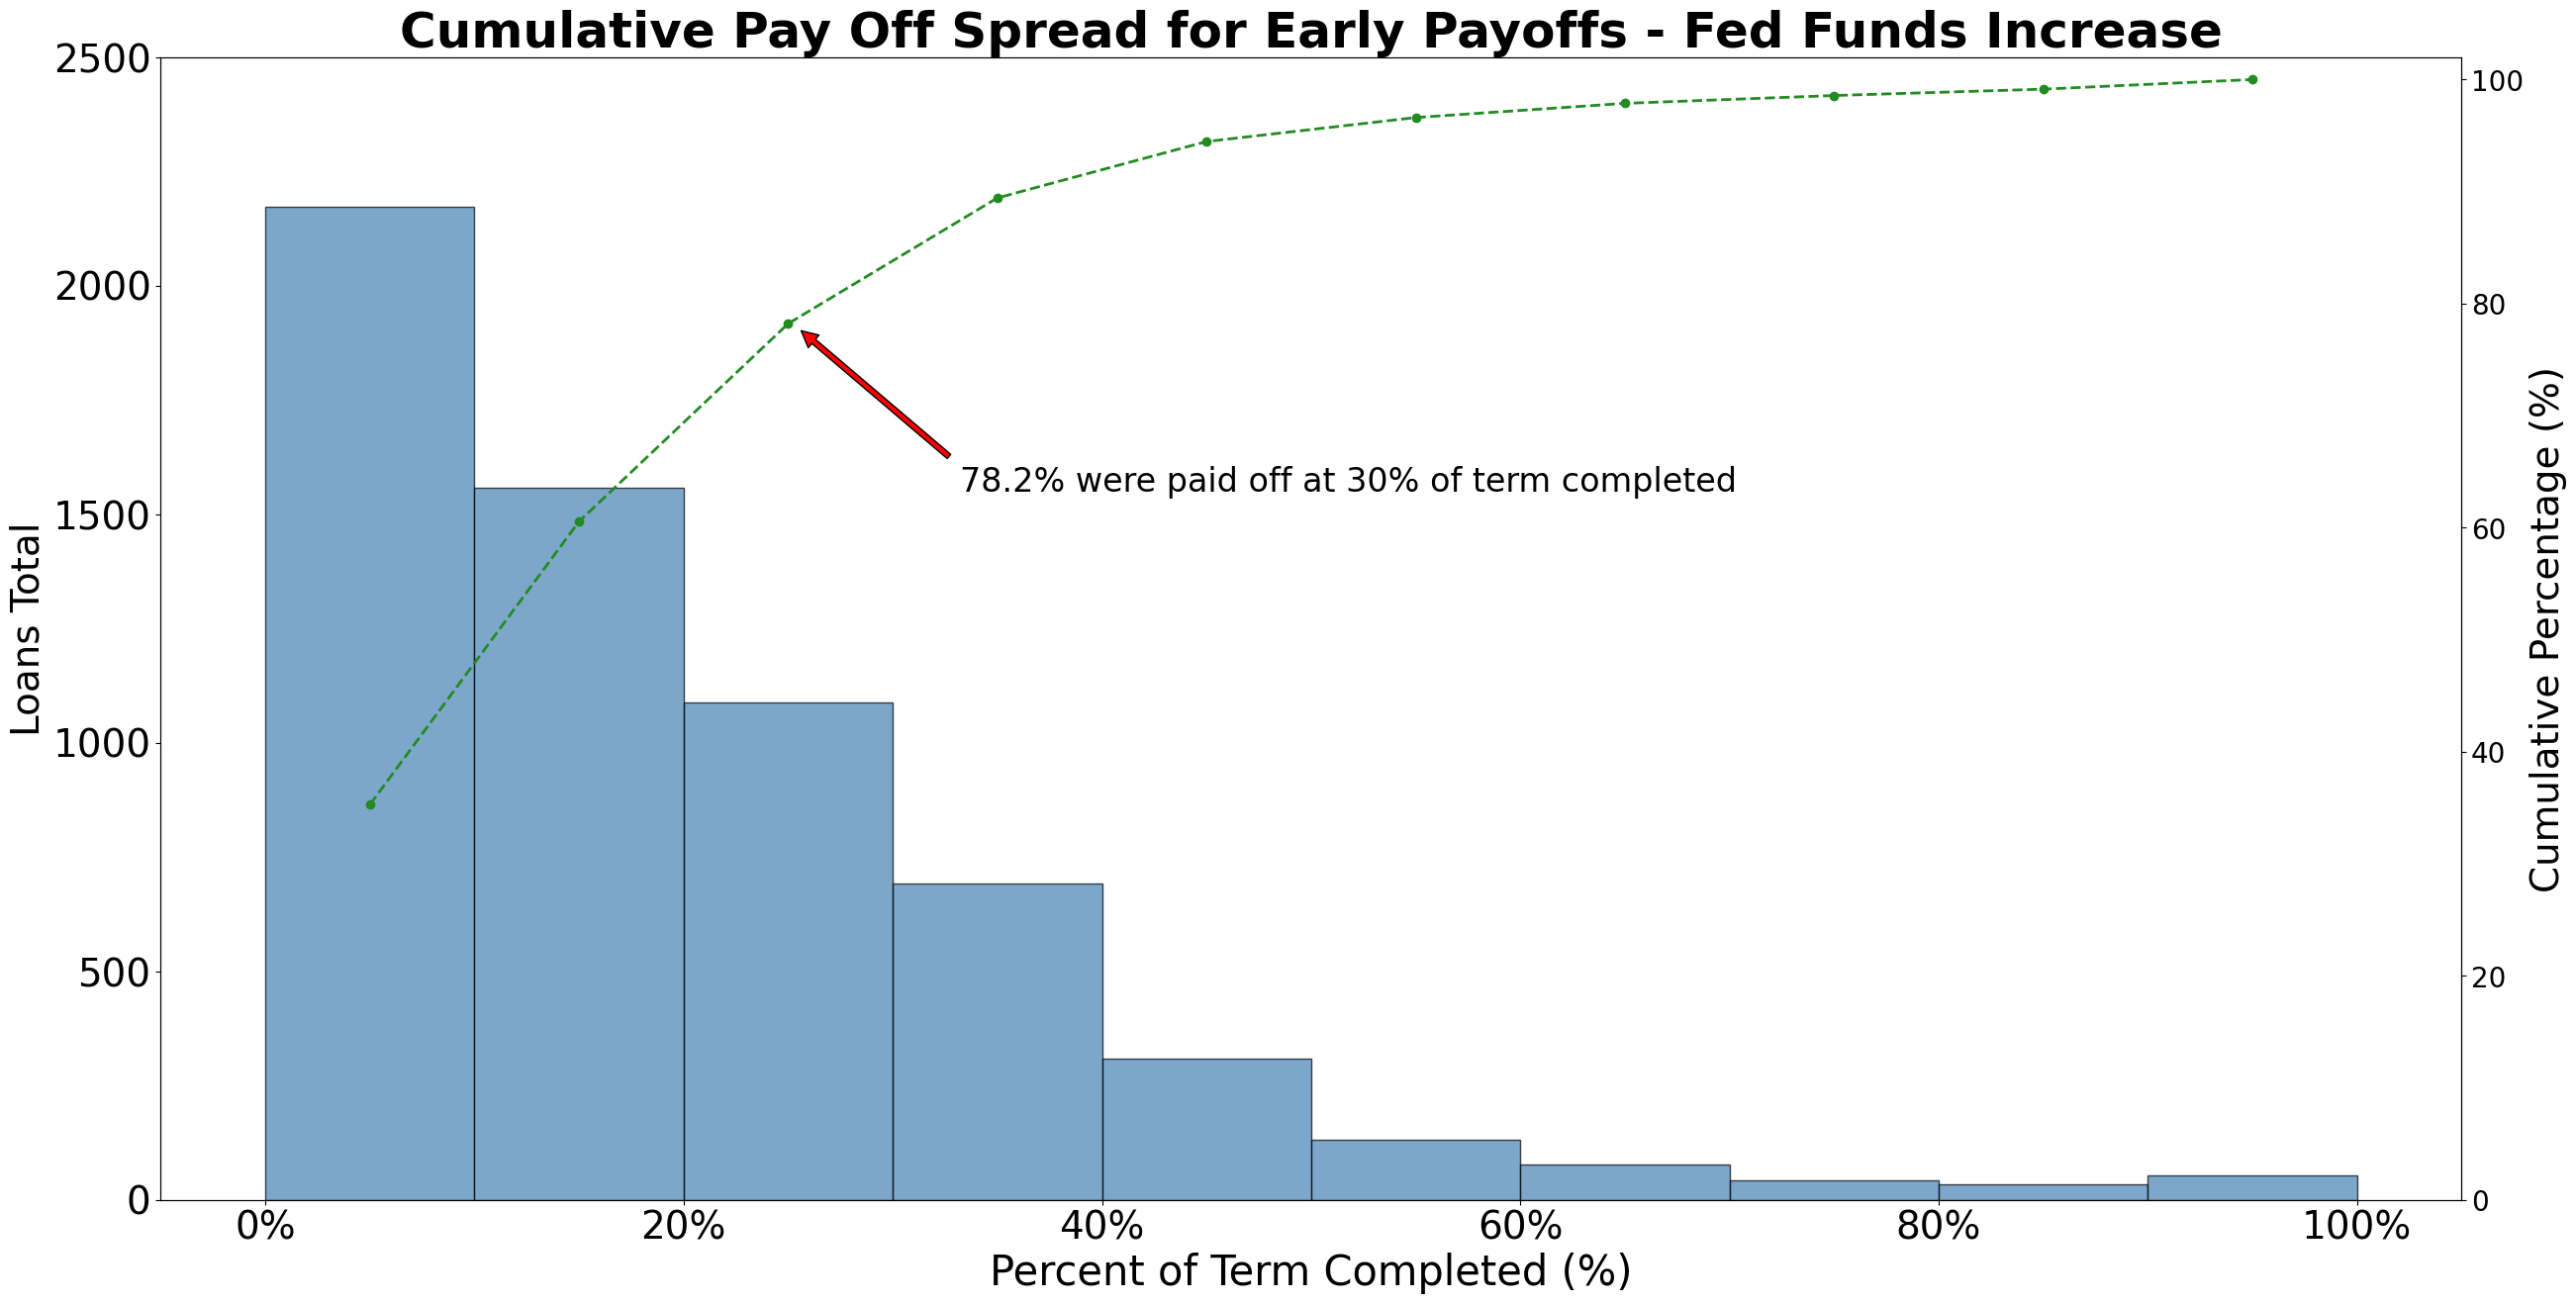

In [18]:
# Only include paid off loans
rate_inc_loans = df[(df['IS_PAID_OFF'] == 'YES') & (df['PRE_FED'] == 'FED FUNDS RATE INCREASE')]
    
fig, ax1 = plt.subplots(figsize=(30, 15))
    
# Create histogram
n, bins, patches = ax1.hist(
        rate_inc_loans['PERCENT_TERM_COMPLETED'],  # Convert to percentage
        bins=10,
        alpha=0.7,
        color='steelblue',
        edgecolor='black'
)
ax1.set_ylim(0, 2500)
ax1.set_yticks([0, 500, 1000, 1500, 2000, 2500])
ax1.set_yticklabels([0, 500, 1000, 1500, 2000, 2500], fontsize=28)
ax1.set_xticklabels(['','0%', '20%', '40%', '60%', '80%', '100%'], fontsize = 28)
ax1.set_ylabel('Loans Total', fontsize=28)
ax1.set_xlabel('Percent of Term Completed (%)', fontsize=30)

bin_centers = 0.5 * (bins[1:] + bins[:-1])

cumulative = np.cumsum(n) / sum(n) * 100
ax2 = plt.twinx()
ax2.plot(bin_centers, cumulative, color='forestgreen', linestyle='--', 
             linewidth=2, marker='o', label='Cumulative Distribution')
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=28)
ax2.set_ylim(0, 102)

ax2.annotate(f'{cumulative[2]:.1f}% were paid off at 30% of term completed',
                 xy=(cumulative[2]-53, cumulative[2]),
                 xytext=(cumulative[2]-45, cumulative[2]-15),
                 arrowprops=dict(facecolor='red', shrink=0.05),
                 fontsize=24)

plt.title('Cumulative Pay Off Spread for Early Payoffs - Fed Funds Increase', fontsize=36, fontweight='bold')
plt.savefig('auto_loan_life_histogram.png', dpi=300)
plt.show()

The comparative analysis of cumulative payoff spreads reveals the most striking evidence yet of how monetary policy shifts have fundamentally altered auto loan portfolio behavior. The contrast between pre-rate increase and rate increase periods demonstrates not just higher prepayment rates, but a complete transformation in the timing of cash flows.

Critical Timing Shift Analysis:

Pre-Fed Rate Environment: The gradual, linear progression shows 78.5% of loans paid off by 60% of term completion, indicating borrowers followed traditional loan lifecycle patterns with steady, predictable prepayment timing distributed relatively evenly across the loan term.

During Fed Rate Increase: The dramatic front-loading reveals 78.2% of loans paid off by just 30% of term completion - representing a 50% acceleration in prepayment timing. This massive shift toward early prepayments fundamentally compresses the effective duration of the entire portfolio.


##### One Month Review

In [19]:
def payoff_curves(df, cohort_var):
    cohort_var = cohort_var
    def calculate_cohort_payoff_curves(df, cohort_var, max_months=12):
        
        # Get valid cohorts
        valid_cohorts = df[cohort_var].unique()
        months = range(0, max_months + 1)
        
        # Pre-allocate results dictionary
        results = {}
        
        for cohort in valid_cohorts:
            cohort_data = df[df[cohort_var] == cohort]
            total_loans = len(cohort_data)
            
            # Vectorized calculation for all months at once
            cohort_results = []
            for month in months:
                paid_off_count = (
                    (cohort_data['IS_PAID_OFF'] == 'YES') & 
                    (cohort_data['MONTHS_TO_PAYOFF'] <= month)
                ).sum()
                
                cumulative_percent = (paid_off_count / total_loans) * 100
                cohort_results.append(cumulative_percent)
            
            results[cohort] = cohort_results
        
        # Create DataFrame with proper structure
        payoff_curves = pd.DataFrame(results, index=months)
        payoff_curves.index.name = 'MONTH'
        
        return payoff_curves

    # Usage
    cumulative_percents_df = calculate_cohort_payoff_curves(df, cohort_var = 'PRE_FED')

    # Create comparison DataFrame
    comparison_df = cumulative_percents_df[['PRE-FED FUNDS RATE INCREASE', 'FED FUNDS RATE INCREASE']].copy()
    comparison_df['RATE_FACTOR'] = (
        comparison_df['FED FUNDS RATE INCREASE'] / 
        comparison_df['PRE-FED FUNDS RATE INCREASE']
    )
    comparison_df.dropna(inplace=True)
    return comparison_df

In [20]:
payoff_curves = payoff_curves(df, cohort_var='PRE_FED')

In [21]:
colors = ['tomato']
for i in np.arange(1, 12, 1):
    colors.append('lightblue')


In [22]:
payoff_curves

,PRE-FED FUNDS RATE INCREASE,FED FUNDS RATE INCREASE,RATE_FACTOR
MONTH,,,
1,0.85,2.35,2.76
2,1.49,3.62,2.43
3,2.15,4.72,2.20
4,2.82,5.89,2.09
5,3.58,6.91,1.93
6,4.36,7.96,1.82
7,5.24,9.04,1.72
8,5.97,10.05,1.68
9,6.81,10.99,1.61


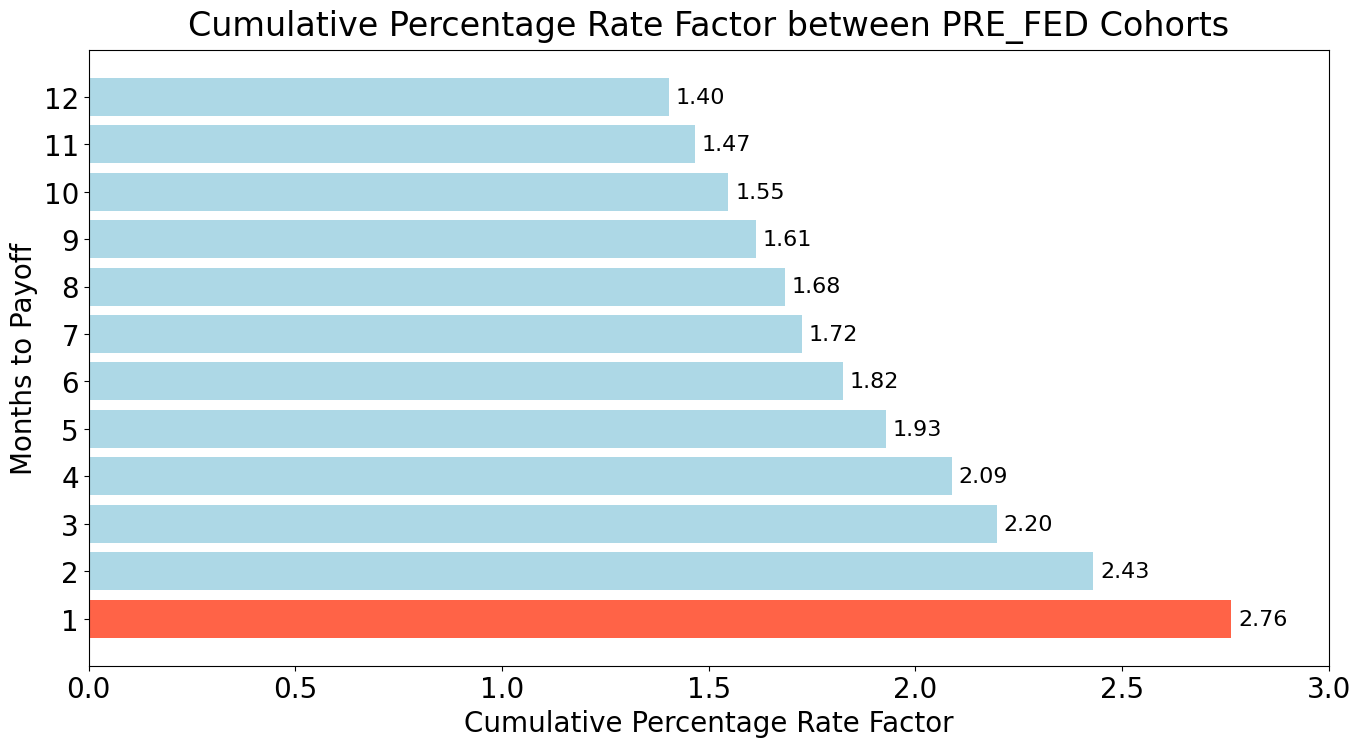

In [23]:
fig, ax = plt.subplots(1, figsize=(16, 8))

bars = ax.barh(payoff_curves.index, payoff_curves['RATE_FACTOR'],
         color = colors)

ax.bar_label(bars, fmt='{:.2f}', padding=5, fontsize=16) # padding adds distance from the bar

ax.set_yticks(np.arange(1, 13, 1))
ax.set_ylabel('Months to Payoff')
ax.set_xticks(np.arange(0, 3.5, 0.5))
ax.set_xlabel('Cumulative Percentage Rate Factor')
ax.set_title('Cumulative Percentage Rate Factor between PRE_FED Cohorts', pad = 15, y = 0.99)

plt.show();

The rate factor analysis identifies one-month payoffs as the highest priority target for portfolio management intervention, with a 2.76x acceleration representing the most severe behavioral shift in the entire prepayment timeline. This extreme first-month volatility demands immediate operational focus and corrective action.

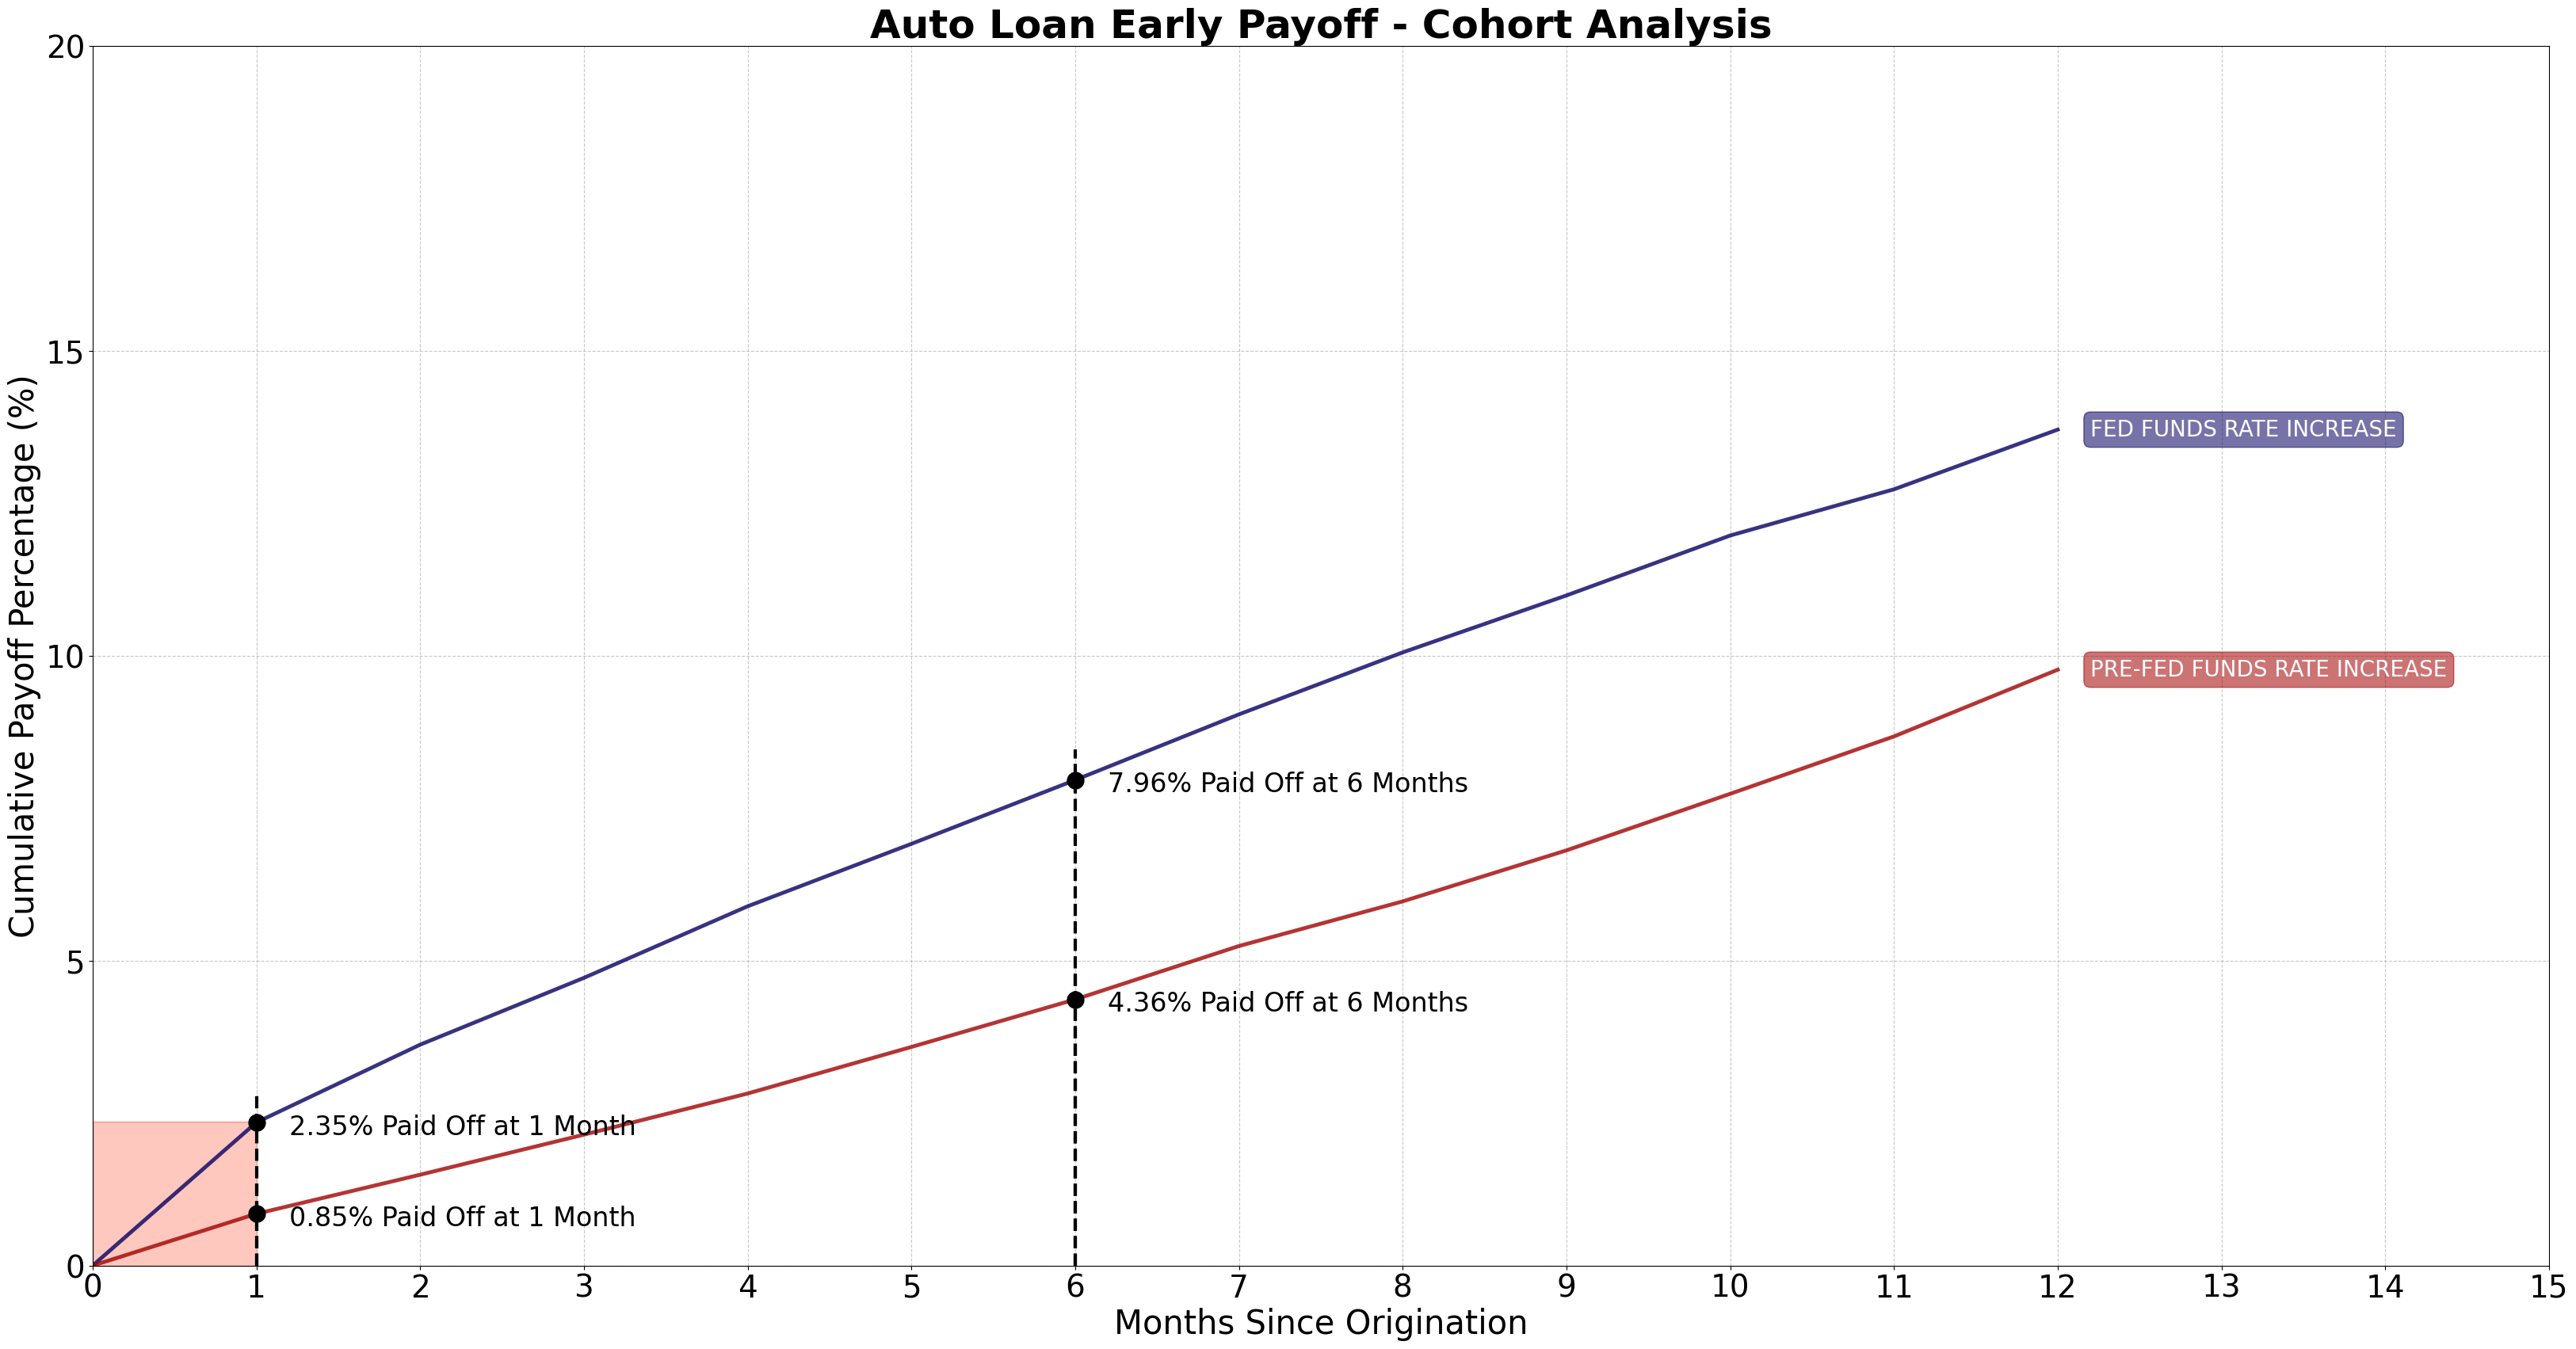

In [24]:
cohort_VAR = 'PRE_FED'

# Only include cohorts with enough loans for statistical reliability
cohort_counts = df.groupby(cohort_VAR).size()
valid_cohorts = cohort_counts.index.to_list()


# Filter to valid cohorts and sort chronologically
valid_cohorts.sort()


#get color palette
colors= [
    '#060061',
    '#a20101'
         ]

# Track maximum month to set x-axis limit
max_month = 0

fig, ax = plt.subplots(1, figsize=(40, 20))
plt.rcParams.update({'font.size': 20})
# Dictionary to store the cumulative payoff percentages for each cohort
cumulative_percents = {}


for i, cohort in enumerate(valid_cohorts):
    # Get all loans in this cohort
    cohort_loans = df[df[cohort_VAR] == cohort]
    total_loans = len(cohort_loans)
        
    # Calculate the maximum months on book for this cohort
    max_cohort_month = cohort_loans['MONTHS_ON_BOOK'].max()
    max_month = 12 #max(max_month, max_cohort_month)
        
    # Create a monthly timeline for this cohort
    months = range(0, 13)
    cumulative_percents[cohort] = []

    # For each month, calculate the cumulative percentage of loans paid off
    for month in months:
        # Count loans paid off by this month
        paid_off_count = ((cohort_loans['IS_PAID_OFF'] == 'YES') & 
                             (cohort_loans['MONTHS_TO_PAYOFF'] <= month)).sum()
            
        # Calculate cumulative percentage
        cumulative_percent = (paid_off_count / total_loans) * 100
        cumulative_percents[cohort].append(cumulative_percent)
        #print(cumulative_percents[cohort])
    # Plot the cumulative payoff curve for this cohort
    ax.plot(months, cumulative_percents[cohort], 
                 marker='', linewidth=3.5, alpha=0.8, 
                 label=f'{cohort} (n={total_loans})',
                 color=colors[i])
    
    # Add Label to the right of each line
    if cumulative_percents[cohort]:
        last_month = months[-1]
        last_value = cumulative_percents[cohort][-1]

        t = ax.text(last_month + 0.2, last_value, f'{cohort}',
                 fontsize=20,
                 verticalalignment='center', fontweight='medium', color='white')
        t.set_bbox(dict(facecolor=colors[i], alpha=0.55, edgecolor=colors[i], boxstyle='round'))

    six_months = cumulative_percents[cohort][6]
    one_month = cumulative_percents[cohort][1]

    #add example leader lines
    ax.vlines(6, 0, six_months+0.5, colors='black', linewidth=3, linestyle='--')
    ax.plot(6, six_months, marker='o', markersize=15, color='black')
    ax.text(6.2, six_months-0.2, f"{round(six_months, 2)}% Paid Off at 6 Months", fontsize=24)

    ax.vlines(1, 0, one_month+0.5, colors='black', linewidth=3, linestyle='--')
    ax.plot(1, one_month, marker='o', markersize=15, color='black')
    ax.text(1.2, one_month-0.2, f"{round(one_month, 2)}% Paid Off at 1 Month", fontsize=24)


#Create a Rectangle patch
plt.gca().add_patch(Rectangle((0,0), 1, 2.36, linewidth=1, edgecolor='r', facecolor='tomato', alpha=0.35))

# Add labels and formatting
plt.xlabel('Months Since Origination', fontsize=30)
plt.ylabel('Cumulative Payoff Percentage (%)', fontsize=30)
plt.title('Auto Loan Early Payoff - Cohort Analysis', fontsize=36, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show every 6 months
plt.xticks([0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], fontsize=28)
plt.xlim(0, 15)
    
# Set y-axis to reasonable limit
plt.ylim(0, 20)
plt.yticks([0, 5, 10, 15, 20], fontsize=28)


plt.savefig('auto_loan_cohort_analysis.png', dpi=300)
plt.show()

The trajectory analysis provides definitive justification for focusing cluster analysis on one-month payoffs, demonstrating both the magnitude and persistence of behavioral changes across rate environments.

##### Auto Product Segmentation

In [25]:
df_1mth_hl = df[['REPORTMONTH', 'PRODUCT_CONDITION', 'PRODUCT_SOURCE', 'PRE_FED']][df['MONTHS_TO_PAYOFF'] == 1]

pivot_pct_ffi = pd.crosstab(df_1mth_hl[df_1mth_hl['PRE_FED'] == 'FED FUNDS RATE INCREASE']['PRODUCT_CONDITION'], df_1mth_hl[df_1mth_hl['PRE_FED'] == 'FED FUNDS RATE INCREASE']['PRODUCT_SOURCE'], normalize='all')

pivot_pct_pf = pd.crosstab(df_1mth_hl[df_1mth_hl['PRE_FED'] == 'PRE-FED FUNDS RATE INCREASE']['PRODUCT_CONDITION'], df_1mth_hl[df_1mth_hl['PRE_FED'] == 'PRE-FED FUNDS RATE INCREASE']['PRODUCT_SOURCE'], normalize='all')

In [26]:
np.arange(0, 0.9, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

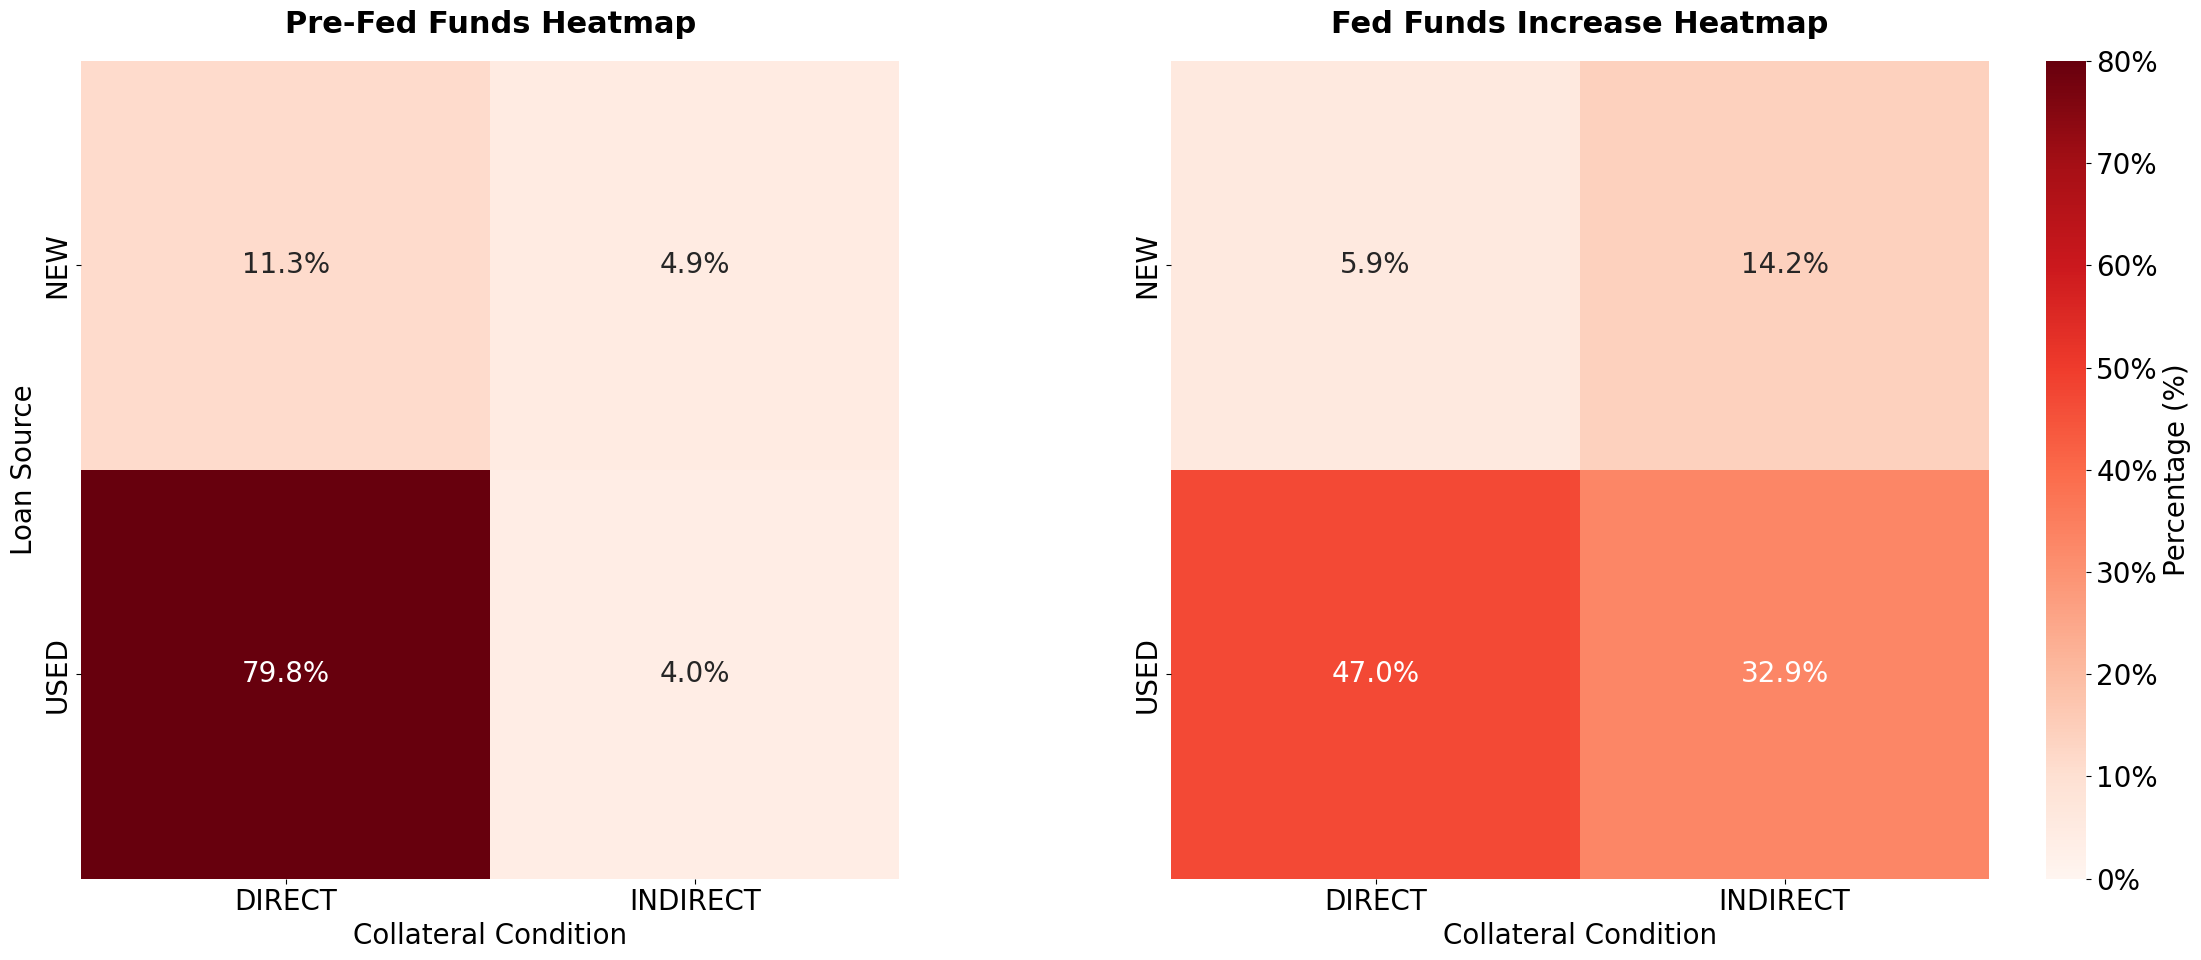

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,10))

vmin = 0
vmax =.8

sns.heatmap(pivot_pct_pf, 
            annot=True,           # Show percentage values in cells
            fmt='.1%',            # Format to 1 decimal place
            cmap='Reds', # Color scheme
            vmin=vmin,
            vmax=vmax,         
            #cbar_kws={'label': 'Percentage (%)'},
            cbar=False,
            square=True,
            ax=ax1)          # Make cells square

ax1.set_title('Pre-Fed Funds Heatmap', fontsize=22, fontweight='bold', pad=20)
ax1.set_xlabel('Collateral Condition')
ax1.set_ylabel('Loan Source')

sns.heatmap(pivot_pct_ffi, 
            annot=True,           # Show percentage values in cells
            fmt='.1%',            # Format to 1 decimal place
            cmap='Reds',         # Color scheme
            vmin=vmin,
            vmax=vmax,
            cbar_kws={'label': 'Percentage (%)'},
            square=True,
            ax=ax2)          # Make cells square

ax2.set_title('Fed Funds Increase Heatmap', fontsize=22, fontweight='bold', pad=20)
ax2.set_xlabel('Collateral Condition')
ax2.set_ylabel('')

# Set custom tick locations and labels
ax2.collections[0].colorbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%'])

plt.tight_layout()
plt.show()


The comparative heatmaps reveal a dramatic restructuring of portfolio composition during the rate increase period, with significant implications for prepayment risk management. The data demonstrates that elevated early payoffs coincide with substantial changes in both product mix and customer segments.

### PART 2: One Month Cluster Analysis

#### Functions

In [28]:
def kmeans_two_stage_clustering(df, target_col='early_payoff', n_clusters=8):
    ### Two-stage clustering using K-means: Fast and interpretable
   
    # Stage 1: K-means clustering on quantitative variables (LTV, credit score, amount)
    # Stage 2: Cross-tabulation with categorical variables (loan type, auto type)

    print(f"K-MEANS CLUSTERING ON {len(df)} LOANS")
   
    # Stage 1: K-means on quantitative variables
    print("Stage 1: K-means clustering on quantitative variables...")
   
    num_cols = ['ltv_orig', 'credit_score_orig', 'amount_orig']
   
    # Standardize numerical variables for K-means
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[num_cols])
   
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    df['cluster'] = cluster_labels + 1  # Start cluster numbering from 1
   
    print(f"  Created {n_clusters} clusters using K-means")
    print(f"  K-means inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")
   
    # Get cluster centers in original scale
    cluster_centers_scaled = kmeans.cluster_centers_
    cluster_centers = scaler.inverse_transform(cluster_centers_scaled)
   
    centers_df = pd.DataFrame(cluster_centers, columns=num_cols)
    centers_df.index = range(1, n_clusters + 1)
    centers_df.index.name = 'Cluster'
   
    print("\nCluster Centers (Original Scale):")
    print(centers_df.round(2))
   
    # Stage 2: Cross-tabulation analysis
    print(f"\nStage 2: Cross-Tabulation Analysis...")
   
    # Basic cluster statistics
    cluster_stats = df.groupby('cluster').agg({
        target_col: ['count', 'sum', 'mean'],
        'ltv_orig': 'mean',
        'credit_score_orig': 'mean',
        'amount_orig': 'mean'
    }).round(3)

    cluster_stats[('early_payoff',  'mean')] = cluster_stats[('early_payoff',  'mean')]*100

    cluster_stats.columns = ['Count', 'Early_Payoffs', 'Early_Rate', 'Avg_LTV', 'Avg_Credit', 'Avg_Amount']
   
    print("\nQuantitative Cluster Summary:")
    print(cluster_stats)
   
    # Identify high-risk clusters
    overall_early_rate = df[target_col].mean()
    high_risk_clusters = cluster_stats[cluster_stats['Early_Rate'] > (overall_early_rate*100) * 1.2]['Early_Rate'].index.tolist()
   
    if high_risk_clusters:
        print(f"\nHigh-risk clusters (>1.5x average rate of {overall_early_rate:.1%}): {high_risk_clusters}")
   
    # Cross-tabulation with categorical variables
    print(f"\n=== CATEGORICAL CROSS-TABULATIONS ===")
   
    # 1. Loan Type vs Clusters
    print("\n1. LOAN TYPE DISTRIBUTION BY CLUSTER:")
    loan_type_crosstab = pd.crosstab(df['cluster'], df['loan_type'], normalize='index')
    print(loan_type_crosstab.round(3)*100)
   
    # 2. Auto Type vs Clusters
    print("\n2. AUTO TYPE DISTRIBUTION BY CLUSTER:")
    auto_type_crosstab = pd.crosstab(df['cluster'], df['auto_type'], normalize='index')
    print(auto_type_crosstab.round(3)*100)
   
    return df, kmeans, cluster_centers

In [29]:
def create_comprehensive_cluster_table(df, cluster_centers, target_col='early_payoff'):
    """
    Create a comprehensive table merging cluster centers, distributions, and statistics
    """
    # 1. Get cluster centers DataFrame
    centers_df = pd.DataFrame(cluster_centers, columns=['ltv_orig', 'credit_score_orig', 'amount_orig'])
    centers_df.index = range(1, len(cluster_centers) + 1)
    centers_df.index.name = 'Cluster'
   
    # 2. Get cluster statistics
    cluster_stats = df.groupby('cluster').agg({
        target_col: ['count', 'sum', 'mean']
    }).round(4)
    cluster_stats.columns = ['Count', 'Early_Payoffs', 'Early_Rate']
  
   
    # 3. Get loan type distribution
    loan_type_dist = pd.crosstab(df['cluster'], df['loan_type'], normalize='index').round(4)
    loan_type_dist.columns = [f'Pct_{col}' for col in loan_type_dist.columns]
   
    # 4. Get auto type distribution  
    auto_type_dist = pd.crosstab(df['cluster'], df['auto_type'], normalize='index').round(4)
    auto_type_dist.columns = [f'Pct_{col}' for col in auto_type_dist.columns]
   
    # 5. Merge all tables
    comprehensive_table = pd.concat([
        centers_df.round(2),
        cluster_stats,
        loan_type_dist,
        auto_type_dist
    ], axis=1)
   
    return comprehensive_table

In [30]:
def plot_comprehensive_cluster_table(comprehensive_table, title="Comprehensive Cluster Analysis"):
    """
    Display the comprehensive cluster table using matplotlib
    """
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.axis('tight')
    ax.axis('off')

    comprehensive_table['credit_score_orig'] = comprehensive_table['credit_score_orig'].astype(int)
   
    # Create the table
    table_data = comprehensive_table.values
    col_labels = comprehensive_table.columns
    row_labels = [f"Cluster {i}" for i in comprehensive_table.index]
   
    # Create table with formatting
    table = ax.table(cellText=table_data,
                    colLabels=col_labels,
                    rowLabels=row_labels,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
   
   
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
   
    # Header styling
    for i in range(len(col_labels)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
   
    # Row label styling
    for i in range(1, len(row_labels) + 1):
        table[(i, -1)].set_facecolor('#E8F5E8')
        table[(i, -1)].set_text_props(weight='bold')
   
    # Highlight high early payoff rates
    early_rate_col = list(comprehensive_table.columns).index('Early_Rate (%)')
    for i in range(1, len(row_labels) + 1):
        early_rate = float(table_data[i-1][early_rate_col])
        if early_rate >= 3.5:  # Highlight rates > 3.5%
            table[(i, early_rate_col)].set_facecolor("#F48691")
            table[(i, early_rate_col)].set_text_props(weight='bold')
        elif early_rate >= 3.0:  # Highlight rates > 3.0%
            table[(i, early_rate_col)].set_facecolor("#F3B49F")
   
    # Color-code LTV values
    ltv_col = list(comprehensive_table.columns).index('ltv_orig')
    for i in range(1, len(row_labels) + 1):
        ltv_value = float(table_data[i-1][ltv_col])
        if ltv_value >= 90:  # High LTV
            table[(i, ltv_col)].set_facecolor("#EEB3BC")
        elif ltv_value <= 70:  # Low LTV
            table[(i, ltv_col)].set_facecolor("#C6F2C6")
   
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
   
    # Add legend
    legend_text = """
    Color Coding: • Red highlight: Early payoff rate > 4% (high risk)  • Orange highlight: Early payoff rate > 3% (medium risk)  • Pink cells: High LTV (>90%)  • Light green cells: Low LTV (<70%)
    """
   
    plt.figtext(0.085, 0.05, legend_text, fontsize=12,
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
   
    plt.show()
   
    return table

In [31]:
def analyze_and_display_clusters(df, cluster_centers, target_col='early_payoff'):
    """
    Complete function to analyze clusters and display comprehensive table
    """

    # Create comprehensive table
    comprehensive_table = create_comprehensive_cluster_table(df, cluster_centers, target_col)

    comprehensive_table['Count'] = comprehensive_table['Count'].astype(int)
    # Format percentage columns
    comprehensive_table['Early_Payoffs'] = round(comprehensive_table['Early_Payoffs'], 0).astype(int)

    comprehensive_table['Early_Rate (%)'] = comprehensive_table['Early_Rate']
    comprehensive_table['Early_Rate (%)'] = round(comprehensive_table['Early_Rate (%)']*100, 2)

    comprehensive_table['Pct_DIRECT (%)'] = comprehensive_table['Pct_DIRECT']
    comprehensive_table['Pct_DIRECT (%)'] = round(comprehensive_table['Pct_DIRECT']*100,2)

    comprehensive_table['Pct_INDIRECT (%)'] = comprehensive_table['Pct_INDIRECT']
    comprehensive_table['Pct_INDIRECT (%)'] = round(comprehensive_table['Pct_INDIRECT']*100,2)

    comprehensive_table['Pct_NEW (%)'] = comprehensive_table['Pct_NEW']
    comprehensive_table['Pct_NEW (%)'] = round(comprehensive_table['Pct_NEW (%)']*100, 2)

    comprehensive_table['Pct_USED (%)'] = comprehensive_table['Pct_USED']
    comprehensive_table['Pct_USED (%)'] = round(comprehensive_table['Pct_USED (%)']*100, 2)

    comprehensive_table.drop(columns=['Early_Rate', 'Pct_DIRECT', 'Pct_INDIRECT', 'Pct_NEW', 'Pct_USED'], inplace=True)

    # Create matplotlib visualization
    plot_comprehensive_cluster_table(comprehensive_table,
                                   "K-means Cluster Analysis: Complete Profile Summary")
   
  
    return comprehensive_table

In [32]:
def cluster_heatmap(df, kmeans_data, figsize, gridpsec):
    """
    Create comprehensive visualizations for K-means clustering results
    """
    fig, axes = plt.subplots(1,2, figsize=figsize, gridspec_kw={'width_ratios': gridpsec})

    sns.heatmap(kmeans_data, annot=True, fmt='.2%', cmap='Reds', vmin=0, vmax=0.07, cbar=False,ax=axes[0])
    axes[0].set_title('Baseline Payoff Rate', fontdict={'weight': 'bold', 'size': 18})
    axes[0].set_ylabel('Cluster', size=18)

    sns.heatmap(df, annot=True, fmt='.2%', cmap='Reds', vmin=0, vmax=0.07, 
                cbar_kws={'label':'Early Payoff %', 'format': FuncFormatter(lambda x, _: '{:.0%}'.format(x))},
                ax=axes[1])
    axes[1].set_title('Cluster vs Loan/Auto Type Early Payoff Rate', fontdict={'weight': 'bold', 'size': 22})
    axes[1].set_ylabel(None)
    axes[1].set_xlabel('Loan Type - Collateral Condition', size=18)

    plt.show()

In [33]:
def kmeans_cluster(df, target_col='early_payoff', n_clusters=8):
    """
    Two-stage clustering using K-means: Fast and interpretable
   
    Stage 1: K-means clustering on quantitative variables (LTV, credit score, amount)
    Stage 2: Cross-tabulation with categorical variables (loan type, auto type)
    """
   
    num_cols = ['ltv_orig', 'credit_score_orig', 'amount_orig']
    cat_cols = ['loan_type', 'auto_type']
   
    # Standardize numerical variables for K-means
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[num_cols])
   
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    df['cluster'] = cluster_labels + 1  # Start cluster numbering from 1

    # Get cluster centers in original scale
    cluster_centers_scaled = kmeans.cluster_centers_
    cluster_centers = scaler.inverse_transform(cluster_centers_scaled)
   
    centers_df = pd.DataFrame(cluster_centers, columns=num_cols)
    centers_df.index = range(1, n_clusters + 1)
    centers_df.index.name = 'Cluster'
   
    # Basic cluster statistics
    cluster_stats = df.groupby('cluster').agg({
        target_col: ['count', 'sum', 'mean'],
        'ltv_orig': 'mean',
        'credit_score_orig': 'mean',
        'amount_orig': 'mean'
    }).round(3)

    cluster_stats.columns = ['Count', 'Early_Payoffs', 'Early_Rate', 'Avg_LTV', 'Avg_Credit', 'Avg_Amount']

    # Create detailed segments
    df['risk_segment'] = (df['cluster'].astype(str) + '_' +
                         df['loan_type'] + '_' +
                         df['auto_type'])
   
    # Analyze all combinations
    segment_stats = df.groupby('risk_segment').agg({
        target_col: ['count', 'sum', 'mean'],
        'ltv_orig': 'mean',
        'credit_score_orig': 'mean',
        'amount_orig': 'mean'
    }).round(3)
   
    segment_stats.columns = ['Count', 'Early_Payoffs', 'Early_Rate', 'Avg_LTV', 'Avg_Credit', 'Avg_Amount']
   
    return cluster_stats

#### Data Transformation

In [34]:
# Now that we've identified the the msot signficant payoff occurs in the first month once rates began to increase, we need to
# filter the dataset for the period with the fed funds rate increase.
df = df[df['PRE_FED'] == 'FED FUNDS RATE INCREASE'] 

In [35]:
df['EARLY_PAYOFF_1MTH'] = 0 # Create unique column criteria; dummy fill with 0
df['EARLY_PAYOFF_1MTH'].iloc[(df['MONTHS_TO_PAYOFF'] <= 1)] = 1 # create binary classification for easy filtering for clustering

In [36]:
df_filtered = df[['ORIGINAL_LTV', 'CREDIT_SCORE', 'ORIGINAL_BALANCE', 'PRODUCT_SOURCE', 'PRODUCT_CONDITION', 'EARLY_PAYOFF_1MTH']] # Isolate key columns for analysis

In [37]:
#rename columns to match Gower Outputs
df_filtered.columns = ['ltv_orig', 'credit_score_orig', 'amount_orig', 'loan_type', 'auto_type', 'early_payoff'] #renaming columns for easier tracking in clustering functions

#### KNN Clustering of Early Payoffs

In [38]:
print("K-MEANS TWO-STAGE AUTO LOAN CLUSTERING ANALYSIS")
print("=" * 50)

df = df_filtered
   
# Perform K-means two-stage clustering
df_clustered, kmeans, cluster_centers = kmeans_two_stage_clustering(
        df, n_clusters=10  # CHANGE THIS NUMBER TO ADJUST CLUSTER COUNT
    )

K-MEANS TWO-STAGE AUTO LOAN CLUSTERING ANALYSIS
K-MEANS CLUSTERING ON 26667 LOANS
Stage 1: K-means clustering on quantitative variables...
  Created 10 clusters using K-means
  K-means inertia (within-cluster sum of squares): 13296.36

Cluster Centers (Original Scale):
         ltv_orig  credit_score_orig  amount_orig
Cluster                                          
1           71.46             787.26     27945.18
2          129.51             719.79     44471.92
3           91.97               0.00     19222.40
4           96.28             656.37     13813.10
5           99.59             784.86     15415.92
6          135.45             715.55     20004.29
7          102.10             758.19     75472.20
8          102.01             732.21     31376.17
9           50.29             741.00     12112.09
10          92.87             766.57     48979.69

Stage 2: Cross-Tabulation Analysis...

Quantitative Cluster Summary:
         Count  Early_Payoffs  Early_Rate  Avg_LTV  Avg_Cred

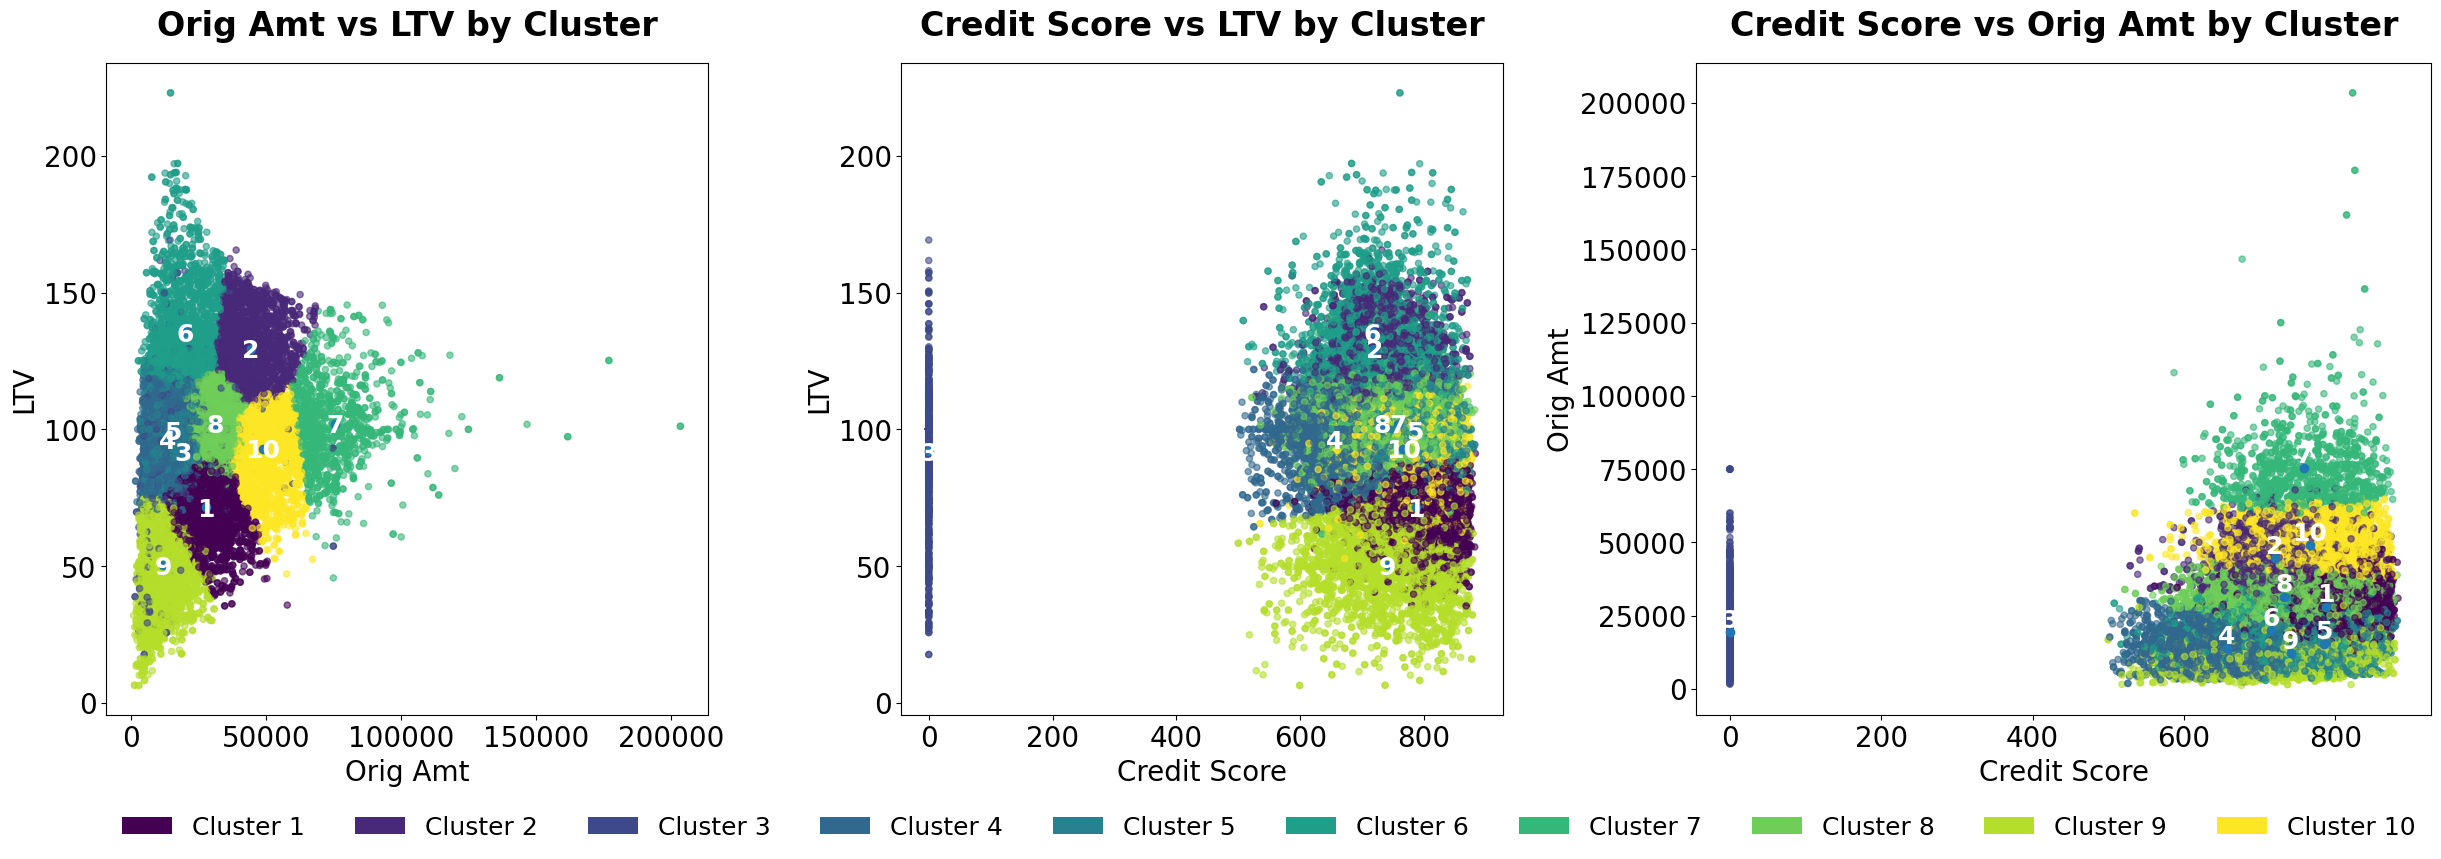

In [39]:

# Create figure with specific subplot sizes (each subplot 6x8 inches)
fig = plt.figure(figsize=(30, 10))  # Increased height to accommodate legend

# Create subplots with equal sizes using GridSpec
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 3, figure=fig, height_ratios=[8, 1], hspace=0.1, wspace=0.3)
gs.set_width_ratios([9, 9, 11])

# Create the three main subplots with equal size
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]



# 1. Orig Amt vs LTV scatter plot
scatter = axes[0].scatter(df['amount_orig'], df['ltv_orig'],
                         c=df['cluster'], cmap='viridis', alpha=0.6, s=20)
axes[0].set_title('Orig Amt vs LTV by Cluster', fontweight='bold', pad=20)
axes[0].set_xlabel('Orig Amt')
axes[0].set_ylabel('LTV')

# Plot cluster centers
centers_df = pd.DataFrame(cluster_centers, columns=['ltv_orig', 'credit_score_orig', 'amount_orig'])
centers_df['Clusters'] = [1,2,3,4,5,6,7,8,9,10]
axes[0].scatter(centers_df['amount_orig'], centers_df['ltv_orig'])
# Add text labels for cluster centers
for index, row in centers_df.iterrows():
    axes[0].text(row['amount_orig'], row['ltv_orig']-5, str(row['Clusters'].astype(int)),
                fontsize=18, fontweight='bold', ha='center', va='bottom', color='white')

# 2. Credit Score vs LTV scatter plot
scatter = axes[1].scatter(df['credit_score_orig'], df['ltv_orig'],
                         c=df['cluster'], cmap='viridis', alpha=0.6, s=20)
axes[1].set_title('Credit Score vs LTV by Cluster', fontweight='bold', pad=20)
axes[1].set_xlabel('Credit Score')
axes[1].set_ylabel('LTV')

# Plot cluster centers
axes[1].scatter(centers_df['credit_score_orig'], centers_df['ltv_orig'])
# Add text labels for cluster centers
for index, row in centers_df.iterrows():
    axes[1].text(row['credit_score_orig'], row['ltv_orig']-5, str(row['Clusters'].astype(int)),
                fontsize=18, fontweight='bold', ha='center', va='bottom', color='white')

# 3. Credit Score vs Orig Amt scatter plot
scatter = axes[2].scatter(df['credit_score_orig'], df['amount_orig'],
                         c=df['cluster'], cmap='viridis', alpha=0.6, s=20)
axes[2].set_title('Credit Score vs Orig Amt by Cluster', fontweight='bold', pad=20)
axes[2].set_xlabel('Credit Score')
axes[2].set_ylabel('Orig Amt')

# Plot cluster centers
axes[2].scatter(centers_df['credit_score_orig'], centers_df['amount_orig'])
# Add text labels for cluster centers
for index, row in centers_df.iterrows():
    axes[2].text(row['credit_score_orig'], row['amount_orig']-5, str(row['Clusters'].astype(int)),
                fontsize=18, fontweight='bold', ha='center', va='bottom', color='white')

# Create categorical legend at the bottom
# Get unique clusters and their colors from the viridis colormap
unique_clusters = sorted(df['cluster'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Create legend elements
legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {cluster}')
                  for i, cluster in enumerate(unique_clusters)]

# Add legend subplot at the bottom spanning all columns
legend_ax = fig.add_subplot(gs[1, :])
legend_ax.axis('off')  # Hide axes
legend_ax.legend(handles=legend_elements, loc='upper center', ncol=len(unique_clusters), 
                frameon=False, fontsize=18, bbox_to_anchor=(0.5, 0.5))

plt.show()

The three-dimensional scatter plot analysis confirms that the K-means algorithm successfully identified ten distinct customer segments with meaningful separation across loan amount, LTV, and credit score dimensions. The visual clustering validates the statistical segmentation and provides insight into the risk and business characteristics driving one-month payoff behavior.

#### Visualize Cluster Summary

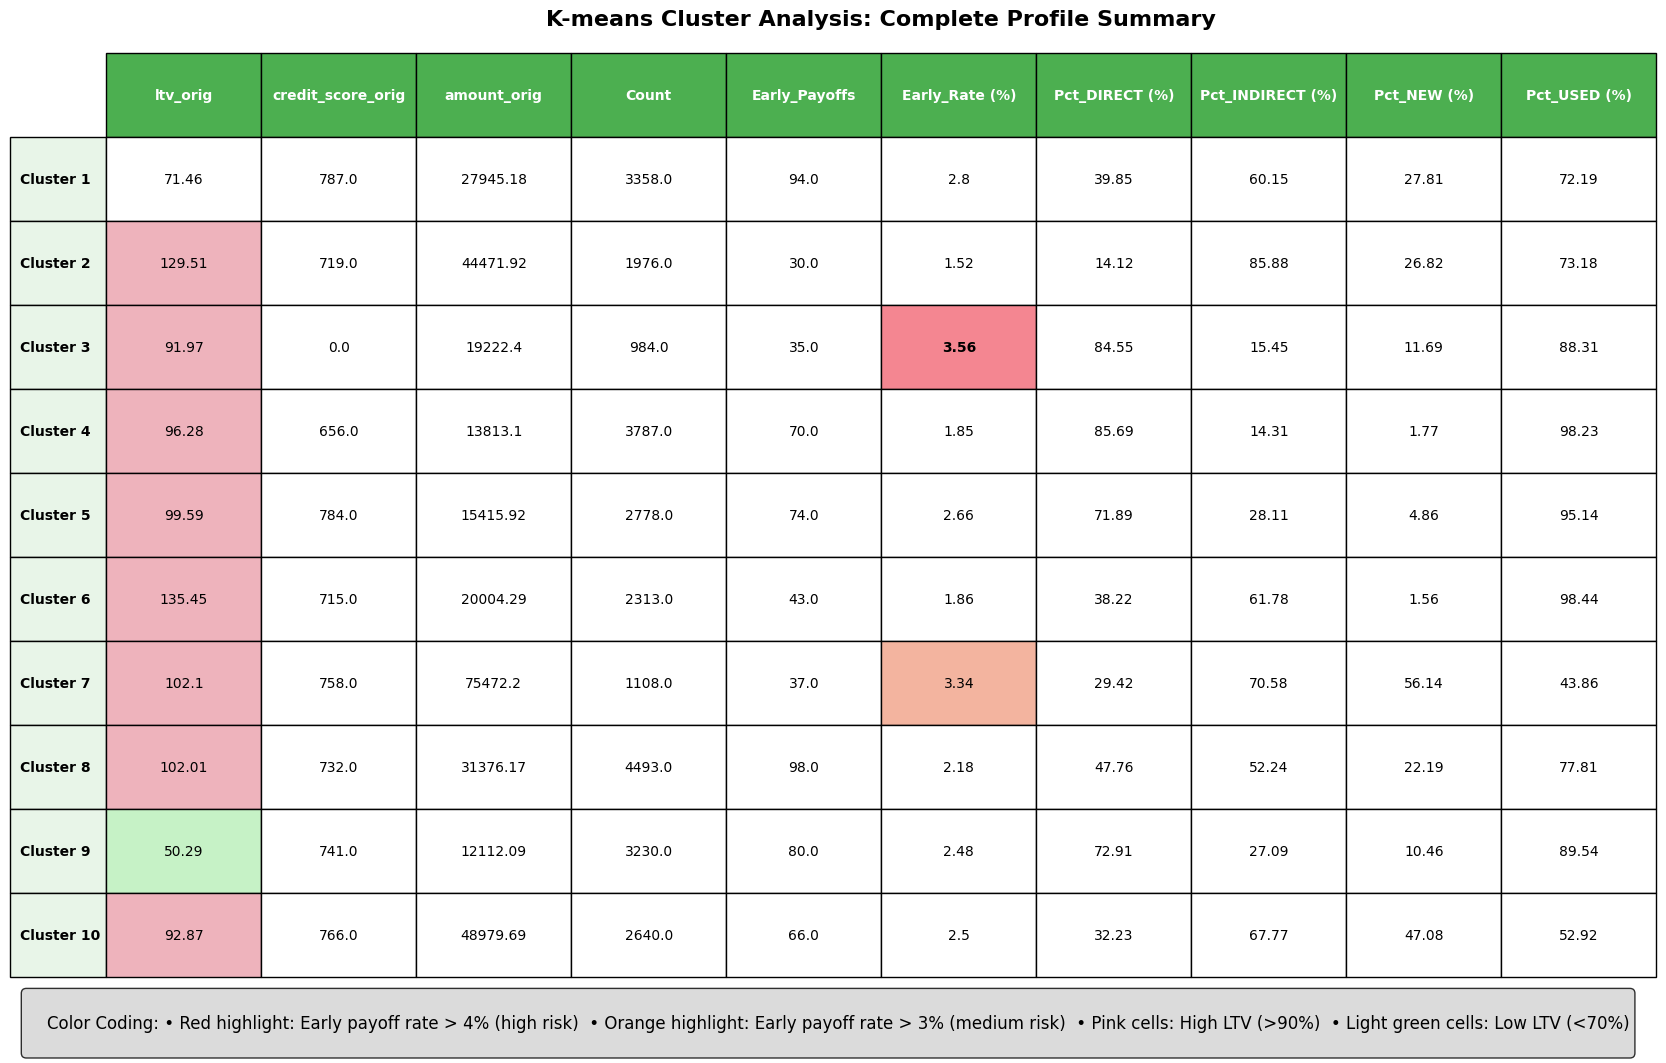

In [40]:
comprehensive_table = analyze_and_display_clusters(df_clustered, cluster_centers)

The color-coded summary table validates the cluster analysis methodology and provides clear business intelligence for targeting one-month payoff interventions. The risk stratification (red = high risk >4%, orange = medium risk >3%) combined with LTV indicators (pink = high LTV >90%, light green = low LTV <70%) creates an actionable framework for portfolio management.

In [41]:
kmeans_data = kmeans_cluster(df, 'early_payoff', 10)
kmeans_data_df = pd.DataFrame(kmeans_data['Early_Rate'])

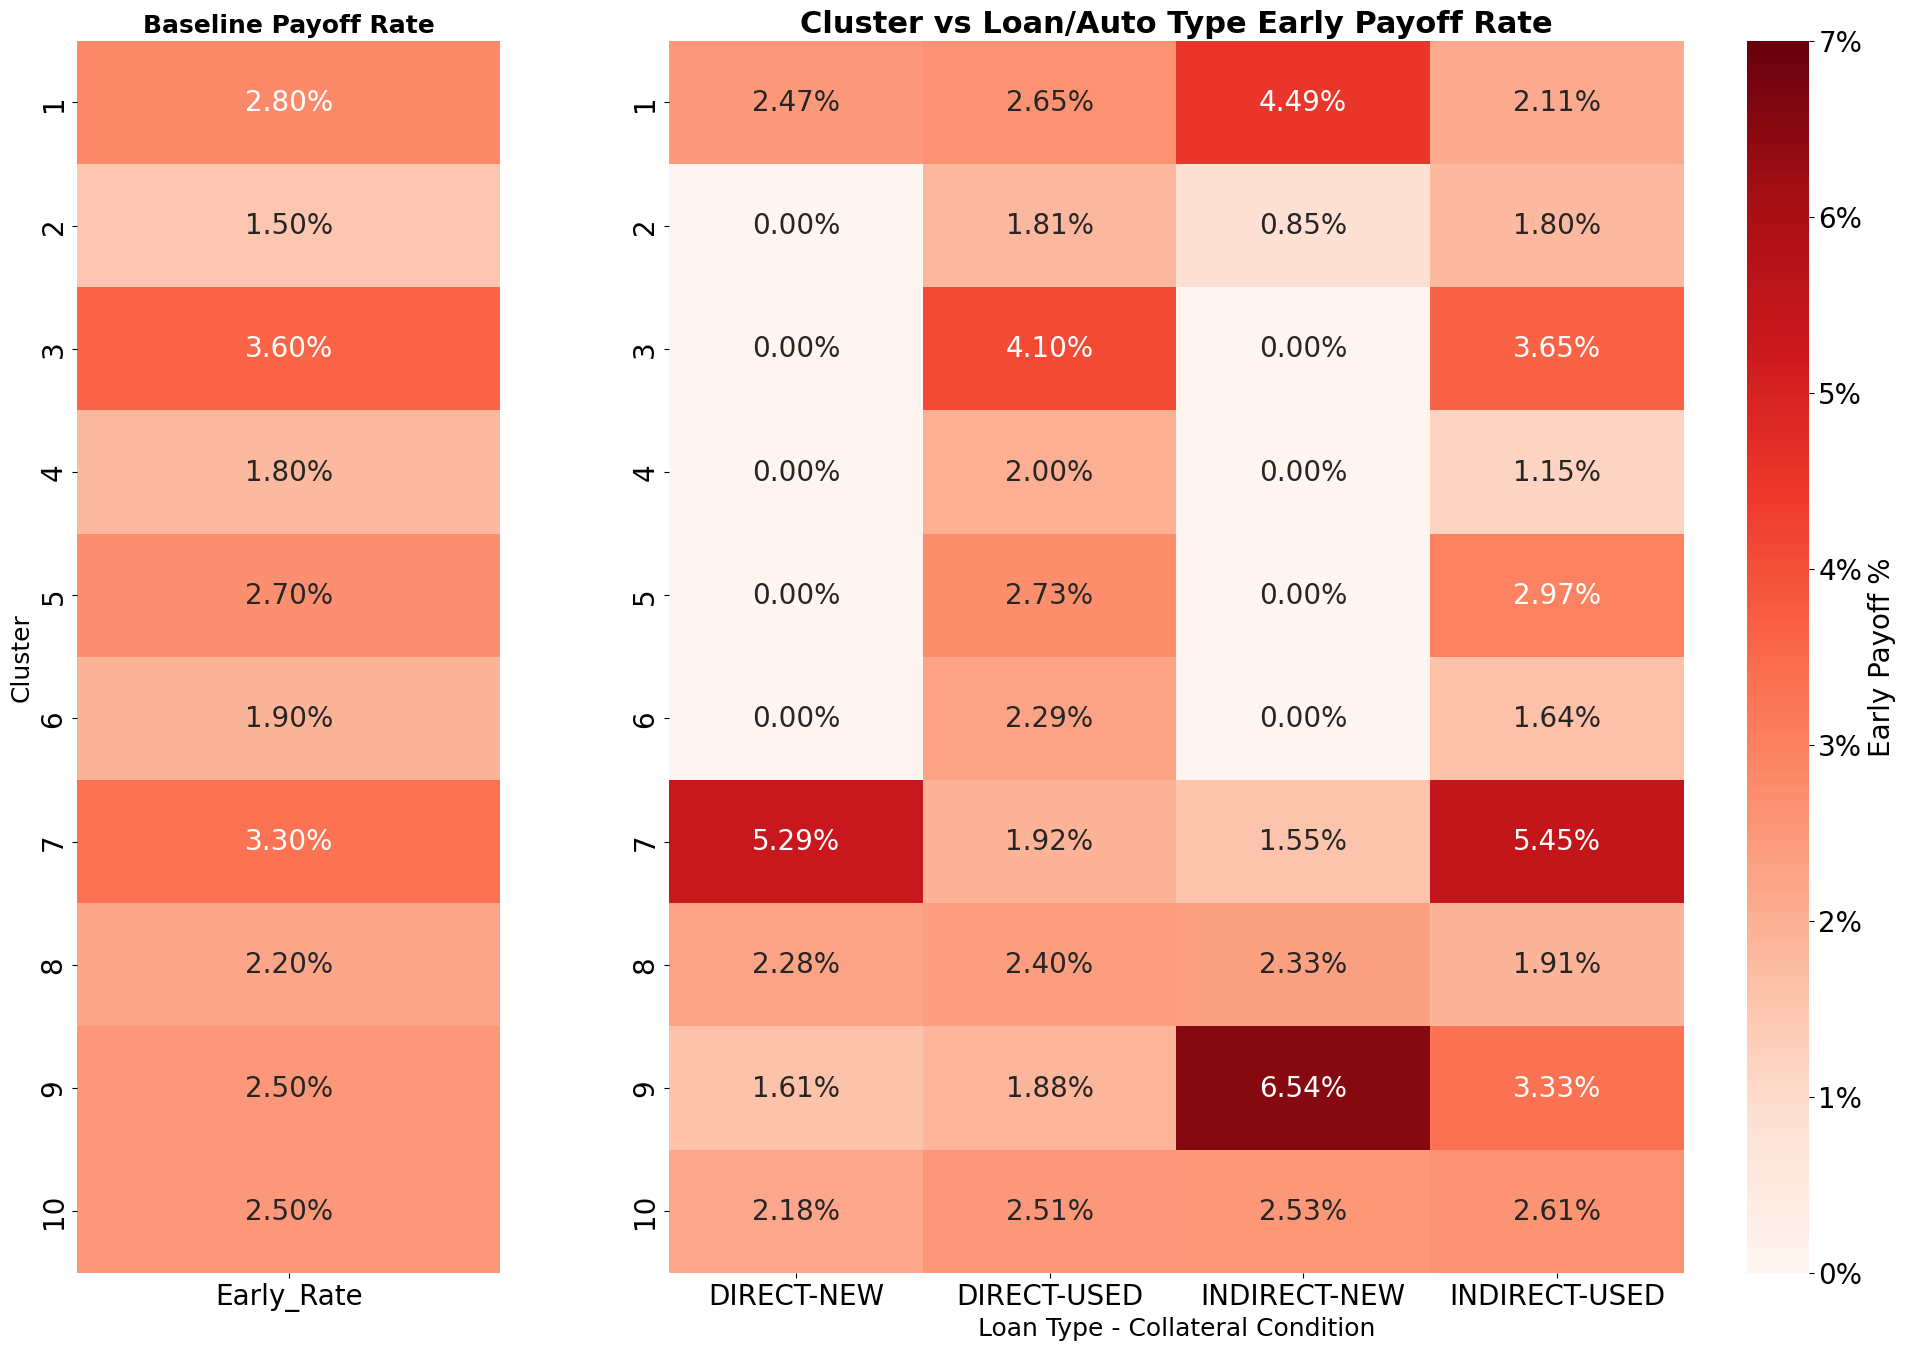

In [42]:
risk_pivot = df.pivot_table(values='early_payoff',
                               index='cluster',
                               columns=['loan_type', 'auto_type'],
                               aggfunc='mean')

cluster_heatmap(risk_pivot, kmeans_data_df, (24,16), [1,3])